# Overview

In the last few years average driving distance on the PGA Tour has increased at a rapid pace, moving the USGA to propose a plan to roll back the golf ball for elite players. While there has been an increase in average club head speed and ball speed on the PGA Tour which would result in increased driving distance, no formal analysis has been done to study the significance of driving distance on scoring on tour or on other metrics of performance. The aim of this project is to address the question of whether driving distance gives an unfair advantage in elite play by employing statistical learning methods to determine causal effect of player skills and accurately model performance on tour using historical data.

We employ a number of statistical learning methods on five years of historical data collected by Matt and Will Courchene on their website. Their site is regularly updated from the PGA Tour stats website, scraping round level performance statistics, for tournaments in a variety of tours. In this project we focus solely on the PGA Tour and our key features are as follows:
- *driving_dist*: Driving distance (yds). 
- *driving_acc*: Driving accuracy (0-1).
- *sg_ott*: Strokes gained of the tee.
- *sg_app*: Strokes gained approach.
- *sg_arg*: Strokes gained around the green.
- *sg_putt*: Strokes gained putting.
- *gir*: Greens in regulation percentage.
- *scrambling*: Scrambling percentage. 
- *prox_rgh*: Proximity from the rough (ft).
- *prox_fw*: Proximity from fairway (ft).

The datasets combined contain more that 100,000 unique samples. However, the data is not exhaustive and so we do engineer the data at several points in the project. Most notably, we drop samples with missing information, drop samples of player who did not make the cut, withdrew, were disqualified, or did not finish, and we average over all features so that we study data at the event level instead of the round level. In addition, we use several lagged features, and since some players may not have multiple samples in each season, they are dropped as well.

# Importing Packages and Data

In [528]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor as DTR, DecisionTreeClassifier as DTC, plot_tree
from sklearn.ensemble import (GradientBoostingClassifier as GBC,
                              RandomForestClassifier as RFC,
                              GradientBoostingRegressor as GBR,
                              RandomForestRegressor as RFR)
from scipy.stats import t
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, f1_score)
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

import warnings
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

In [529]:
# Import data
data_df = pd.read_csv('2017.csv')

for year in range(2018, 2024):
    year_data = pd.read_csv(f'{year}.csv')
    data_df = pd.concat([data_df, year_data])

print(data_df.describe())

                year         season       event_id         dg_id  \
count  124771.000000  124771.000000  124771.000000  1.247710e+05   
mean     2019.995167    2020.177726     199.069487  1.431346e+04   
std         2.020806       2.021710     231.725860  8.031460e+04   
min      2017.000000    2017.000000       2.000000  2.400000e+01   
25%      2018.000000    2018.000000      13.000000  8.769000e+03   
50%      2020.000000    2020.000000      33.000000  1.383100e+04   
75%      2022.000000    2022.000000     480.000000  1.753600e+04   
max      2023.000000    2023.000000     549.000000  1.005830e+07   

           round_num     course_num     course_par     start_hole  \
count  124771.000000  124771.000000  124771.000000  124771.000000   
mean        2.213631     535.490370      71.145603       4.401039   
std         1.077864     330.998118       0.833680       4.361523   
min         1.000000       4.000000      70.000000       1.000000   
25%         1.000000     237.000000      7

In [530]:
data_df.columns

Index(['tour', 'year', 'season', 'event_completed', 'event_name', 'event_id',
       'player_name', 'dg_id', 'fin_text', 'round_num', 'course_name',
       'course_num', 'course_par', 'start_hole', 'teetime', 'round_score',
       'sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total',
       'driving_dist', 'driving_acc', 'gir', 'scrambling', 'prox_rgh',
       'prox_fw', 'great_shots', 'poor_shots'],
      dtype='object')

# Exploratory Analysis

## Preproccessing and Distributions

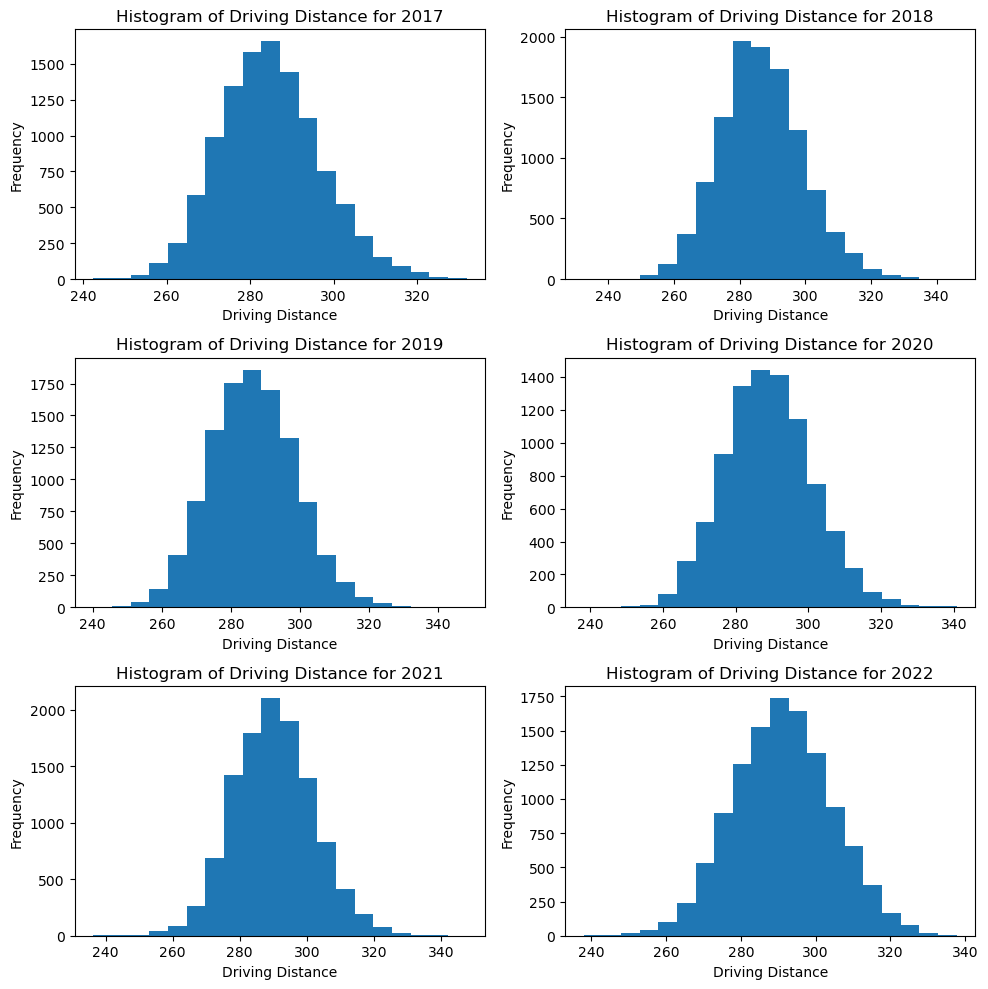

In [531]:
# Drop rows with missing values
data_df.dropna(inplace=True)
data_df.drop(['tour', 'year', 'season', 'event_name', 'course_name'], inplace=True, axis=1)

# Set "event_completed" column as datetime type with format "yyyy-mm-dd"
data_df['event_completed'] = pd.to_datetime(data_df['event_completed'], format='%Y-%m-%d')

data_df['year'] = data_df['event_completed'].dt.year
data_df['month'] = data_df['event_completed'].dt.month
data_df['day'] = data_df['event_completed'].dt.day

# Select columns
X = data_df[['event_id', 'dg_id', 'round_num', 'course_num', 'course_par', 
            'start_hole', 'teetime', 'driving_dist', 'driving_acc', 'gir', 
            'scrambling', 'prox_rgh', 'prox_fw', 'year']]
Y = data_df['round_score']

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

# Create a subplot figure of (3,2)
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# Plot histogram for each year with increased number of bins
for year, axs in zip(range(2017, 2024), axes.flatten()):
    year_data = X_train[X_train['year'] == year]
    year_data['driving_dist'].plot.hist(ax=axs, bins=20)  # Increase the number of bins to 20
    axs.set_title(f'Histogram of Driving Distance for {year}')
    axs.set_xlabel('Driving Distance')
    axs.set_ylabel('Frequency')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

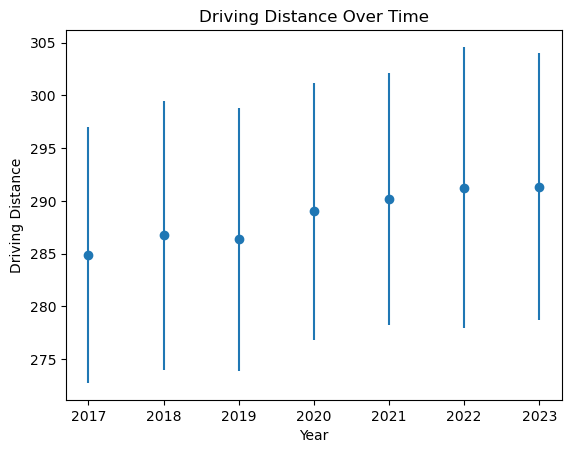

In [532]:
# Group data by year and calculate mean and standard deviation of driving distance
grouped_data = X_train.groupby('year')['driving_dist']
mean_distance = grouped_data.mean()
std_distance = grouped_data.std()

# Plot driving distance over time with error bars
plt.errorbar(mean_distance.index, mean_distance, yerr=std_distance, fmt='o')
plt.title('Driving Distance Over Time')
plt.xlabel('Year')
plt.ylabel('Driving Distance')
plt.show()

In [533]:
# Define the dependent variable (driving distance) and independent variable (time)
y = X_train['driving_dist']
X = X_train['year']

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           driving_dist   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     2654.
Date:                Fri, 15 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:52:47   Log-Likelihood:            -2.9895e+05
No. Observations:               75769   AIC:                         5.979e+05
Df Residuals:                   75767   BIC:                         5.979e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2043.7423     45.276    -45.140      0.0

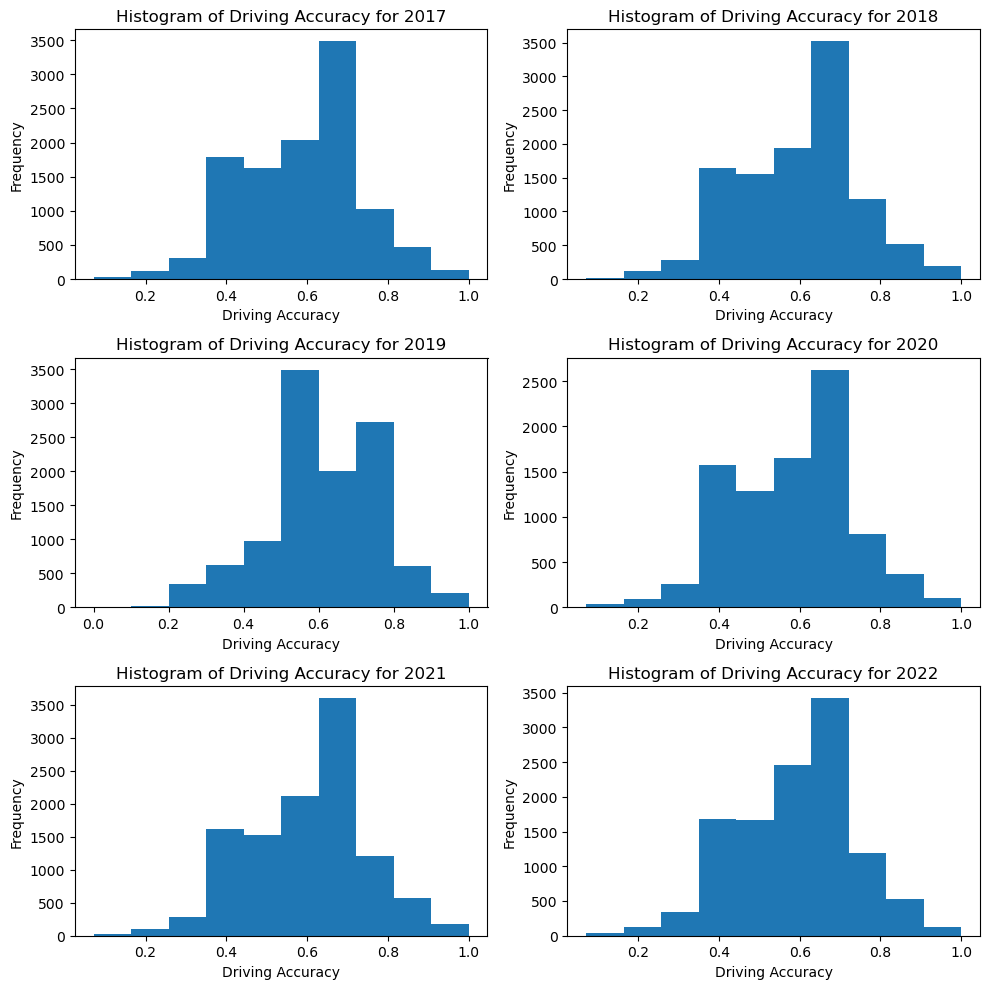

In [534]:
# Create a subplot figure of (3,2)
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# Plot histogram for each year
for year, axs in zip(range(2017, 2024), axes.flatten()):
    year_data = X_train[X_train['year'] == year]
    year_data['driving_acc'].plot.hist(ax=axs)
    axs.set_title(f'Histogram of Driving Accuracy for {year}')
    axs.set_xlabel('Driving Accuracy')
    axs.set_ylabel('Frequency')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

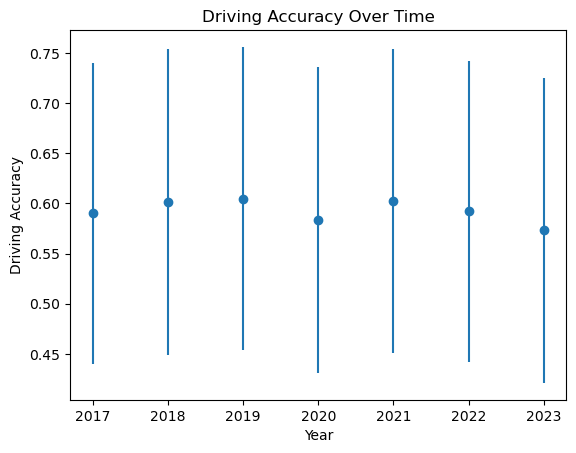

In [535]:
# Group data by year and calculate mean and standard deviation of driving accuracy
grouped_data = X_train.groupby('year')['driving_acc']
mean_accuracy = grouped_data.mean()
std_accuracy = grouped_data.std()

# Plot driving accuracy over time with error bars
plt.errorbar(mean_accuracy.index, mean_accuracy, yerr=std_accuracy, fmt='o')
plt.title('Driving Accuracy Over Time')
plt.xlabel('Year')
plt.ylabel('Driving Accuracy')
plt.show()

In [536]:
# Define the dependent variable (driving accuracy) and independent variable (time)
y = X_train['driving_acc']
X = X_train['year']

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            driving_acc   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     86.00
Date:                Fri, 15 Dec 2023   Prob (F-statistic):           1.84e-20
Time:                        13:52:48   Log-Likelihood:                 35402.
No. Observations:               75769   AIC:                        -7.080e+04
Df Residuals:                   75767   BIC:                        -7.078e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6820      0.549     10.354      0.0

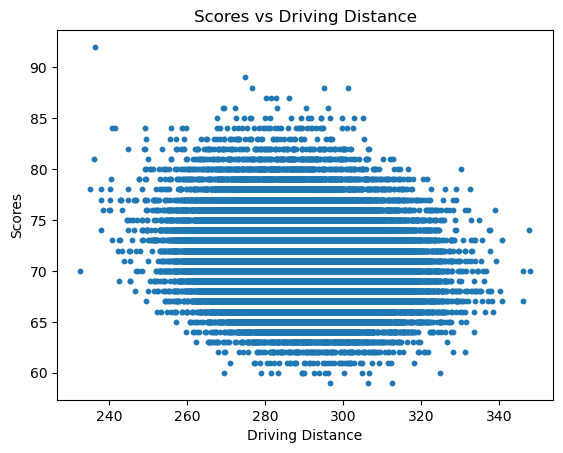

In [537]:
plt.scatter(X_train['driving_dist'], y_train, s=10)
plt.title('Scores vs Driving Distance')
plt.xlabel('Driving Distance')
plt.ylabel('Scores')
plt.show()

In [538]:
# Define the dependent variable (scores) and independent variable (driving distance)
y = y_train
X = X_train['driving_dist']

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            round_score   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1851.
Date:                Fri, 15 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:52:48   Log-Likelihood:            -1.9743e+05
No. Observations:               75769   AIC:                         3.949e+05
Df Residuals:                   75767   BIC:                         3.949e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           82.3776      0.270    304.979   

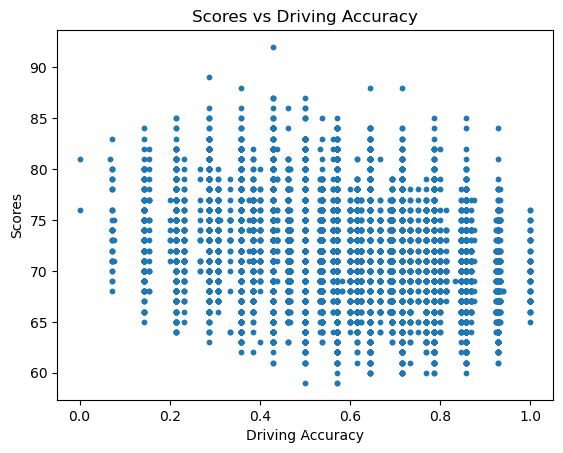

In [539]:
plt.scatter(X_train['driving_acc'], y_train, s=10)
plt.title('Scores vs Driving Accuracy')
plt.xlabel('Driving Accuracy')
plt.ylabel('Scores')
plt.show()

We observe in our preliminary analysis above that while driving distance has been consistently increasing year over year on the PGA Tour, players are not any more accurate off the tee. This confirms the main argument surrounding the roll back of the golf ball: while golfer's aren't becoming any more skilled, technology is continuing to improve, making golf courses designed in the last few decades be played not the way they were intended.

## Only those who completed tournament

In [540]:
# Define the predictors and target variable
finished = data_df[~data_df['fin_text'].isin(['CUT', 'WD', 'DQ', 'MDF'])].copy(deep=True)
finished = finished.sort_values('event_completed')
finished.dropna(inplace=True)

finished['score']= finished['round_score'].values - finished['course_par'].values

We elect to study just the samples of players who finished the tournament corresponding to the sample. In addition we choose to normalize the scores relative to the par of the course in order to provide a more fair study of the relationship between distance, accuracy, and scoring.

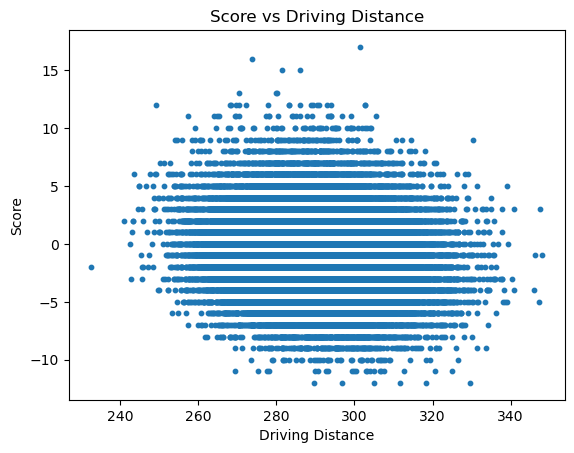

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1130.
Date:                Fri, 15 Dec 2023   Prob (F-statistic):          1.20e-245
Time:                        13:52:48   Log-Likelihood:            -1.6690e+05
No. Observations:               66827   AIC:                         3.338e+05
Df Residuals:                   66825   BIC:                         3.338e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.5345      1.477     32.851      0.0

In [541]:
plt.scatter(finished['driving_dist'], finished['score'], s=10)
plt.title('Score vs Driving Distance')
plt.xlabel('Driving Distance')
plt.ylabel('Score')
plt.show()


finished['ln_dist'] = np.log(finished['driving_dist'].values)

# Define the dependent variable (score) and independent variable (ln_dist)
y = finished['score']
X = finished['ln_dist']

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

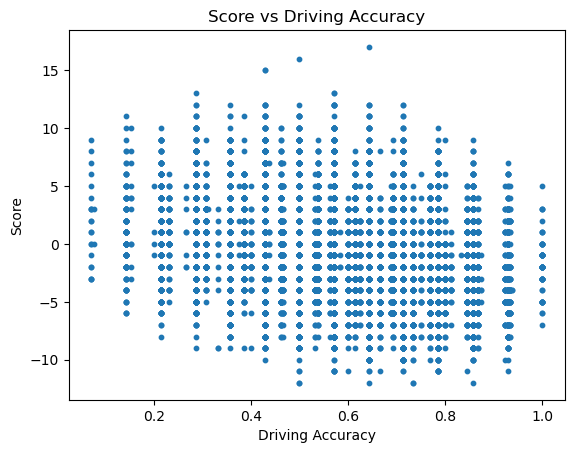

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     4305.
Date:                Fri, 15 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:52:49   Log-Likelihood:            -1.6537e+05
No. Observations:               66827   AIC:                         3.308e+05
Df Residuals:                   66825   BIC:                         3.308e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.8219      0.046     39.363      

In [542]:
plt.scatter(finished['driving_acc'], finished['score'], s=10)
plt.title('Score vs Driving Accuracy')
plt.xlabel('Driving Accuracy')
plt.ylabel('Score')
plt.show()

# Define the dependent variable (score) and independent variable (driving_acc)
y = finished['score']
X = finished['driving_acc']

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

In [543]:
# Create an empty list to store the regression models
regression_models = []

# Iterate over the years
for year in range(2017, 2024):
    # Filter the data for the current year
    year_data = finished[finished['year'] == year]
    
    # Define the dependent variable (score) and independent variable (ln_dist)
    y = year_data['score']
    X = year_data['ln_dist']
    
    # Add a constant term to the independent variable
    X = sm.add_constant(X)
    
    # Fit the OLS model
    model = sm.OLS(y, X).fit()
    
    # Append the model to the list
    regression_models.append(model)

# Print the summary of each model
for year, model in zip(range(2017, 2024), regression_models):
    print(f"Regression Model for Year {year}:")
    print(model.summary())
    print()

Regression Model for Year 2017:
                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     83.62
Date:                Fri, 15 Dec 2023   Prob (F-statistic):           7.17e-20
Time:                        13:52:49   Log-Likelihood:                -24881.
No. Observations:               10071   AIC:                         4.977e+04
Df Residuals:                   10069   BIC:                         4.978e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.421

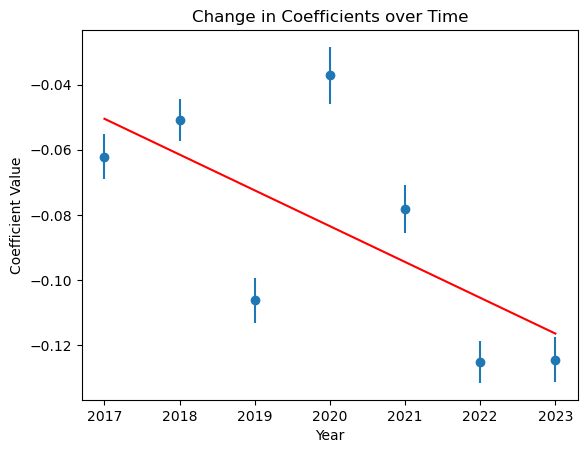

In [544]:
# Create empty lists to store the coefficients and standard errors
years = []
slopes = []
errors = []

# Iterate over the regression models
for year, model in zip(range(2017, 2024), regression_models):
    years.append(year)
    slopes.append(model.params[1] / 100)
    errors.append(model.bse[1] / 100)  # Divide the standard error by 100

# Plot the change in slopes with error bars
plt.errorbar(years, slopes, yerr=errors, fmt='o')

# Calculate the line of best fit
coefficients = np.polyfit(years, slopes, 1)
line = np.polyval(coefficients, years)

# Plot the line of best fit
plt.plot(years, line, color='red')

# Set the labels and title
plt.xlabel('Year')
plt.ylabel('Coefficient Value')
plt.title('Change in Coefficients over Time')

# Show the plot
plt.show()

In [545]:
finished['is_2020'] = (finished['year'] == 2020).astype(int)

# Define the dependent variable (score) and independent variable (ln_dist)
y = finished['score']
X = finished[['ln_dist', 'is_2020']]

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     578.8
Date:                Fri, 15 Dec 2023   Prob (F-statistic):          5.80e-250
Time:                        13:52:49   Log-Likelihood:            -1.6689e+05
No. Observations:               66827   AIC:                         3.338e+05
Df Residuals:                   66824   BIC:                         3.338e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.6540      1.477     32.934      0.0

/Users/christiangarcia/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


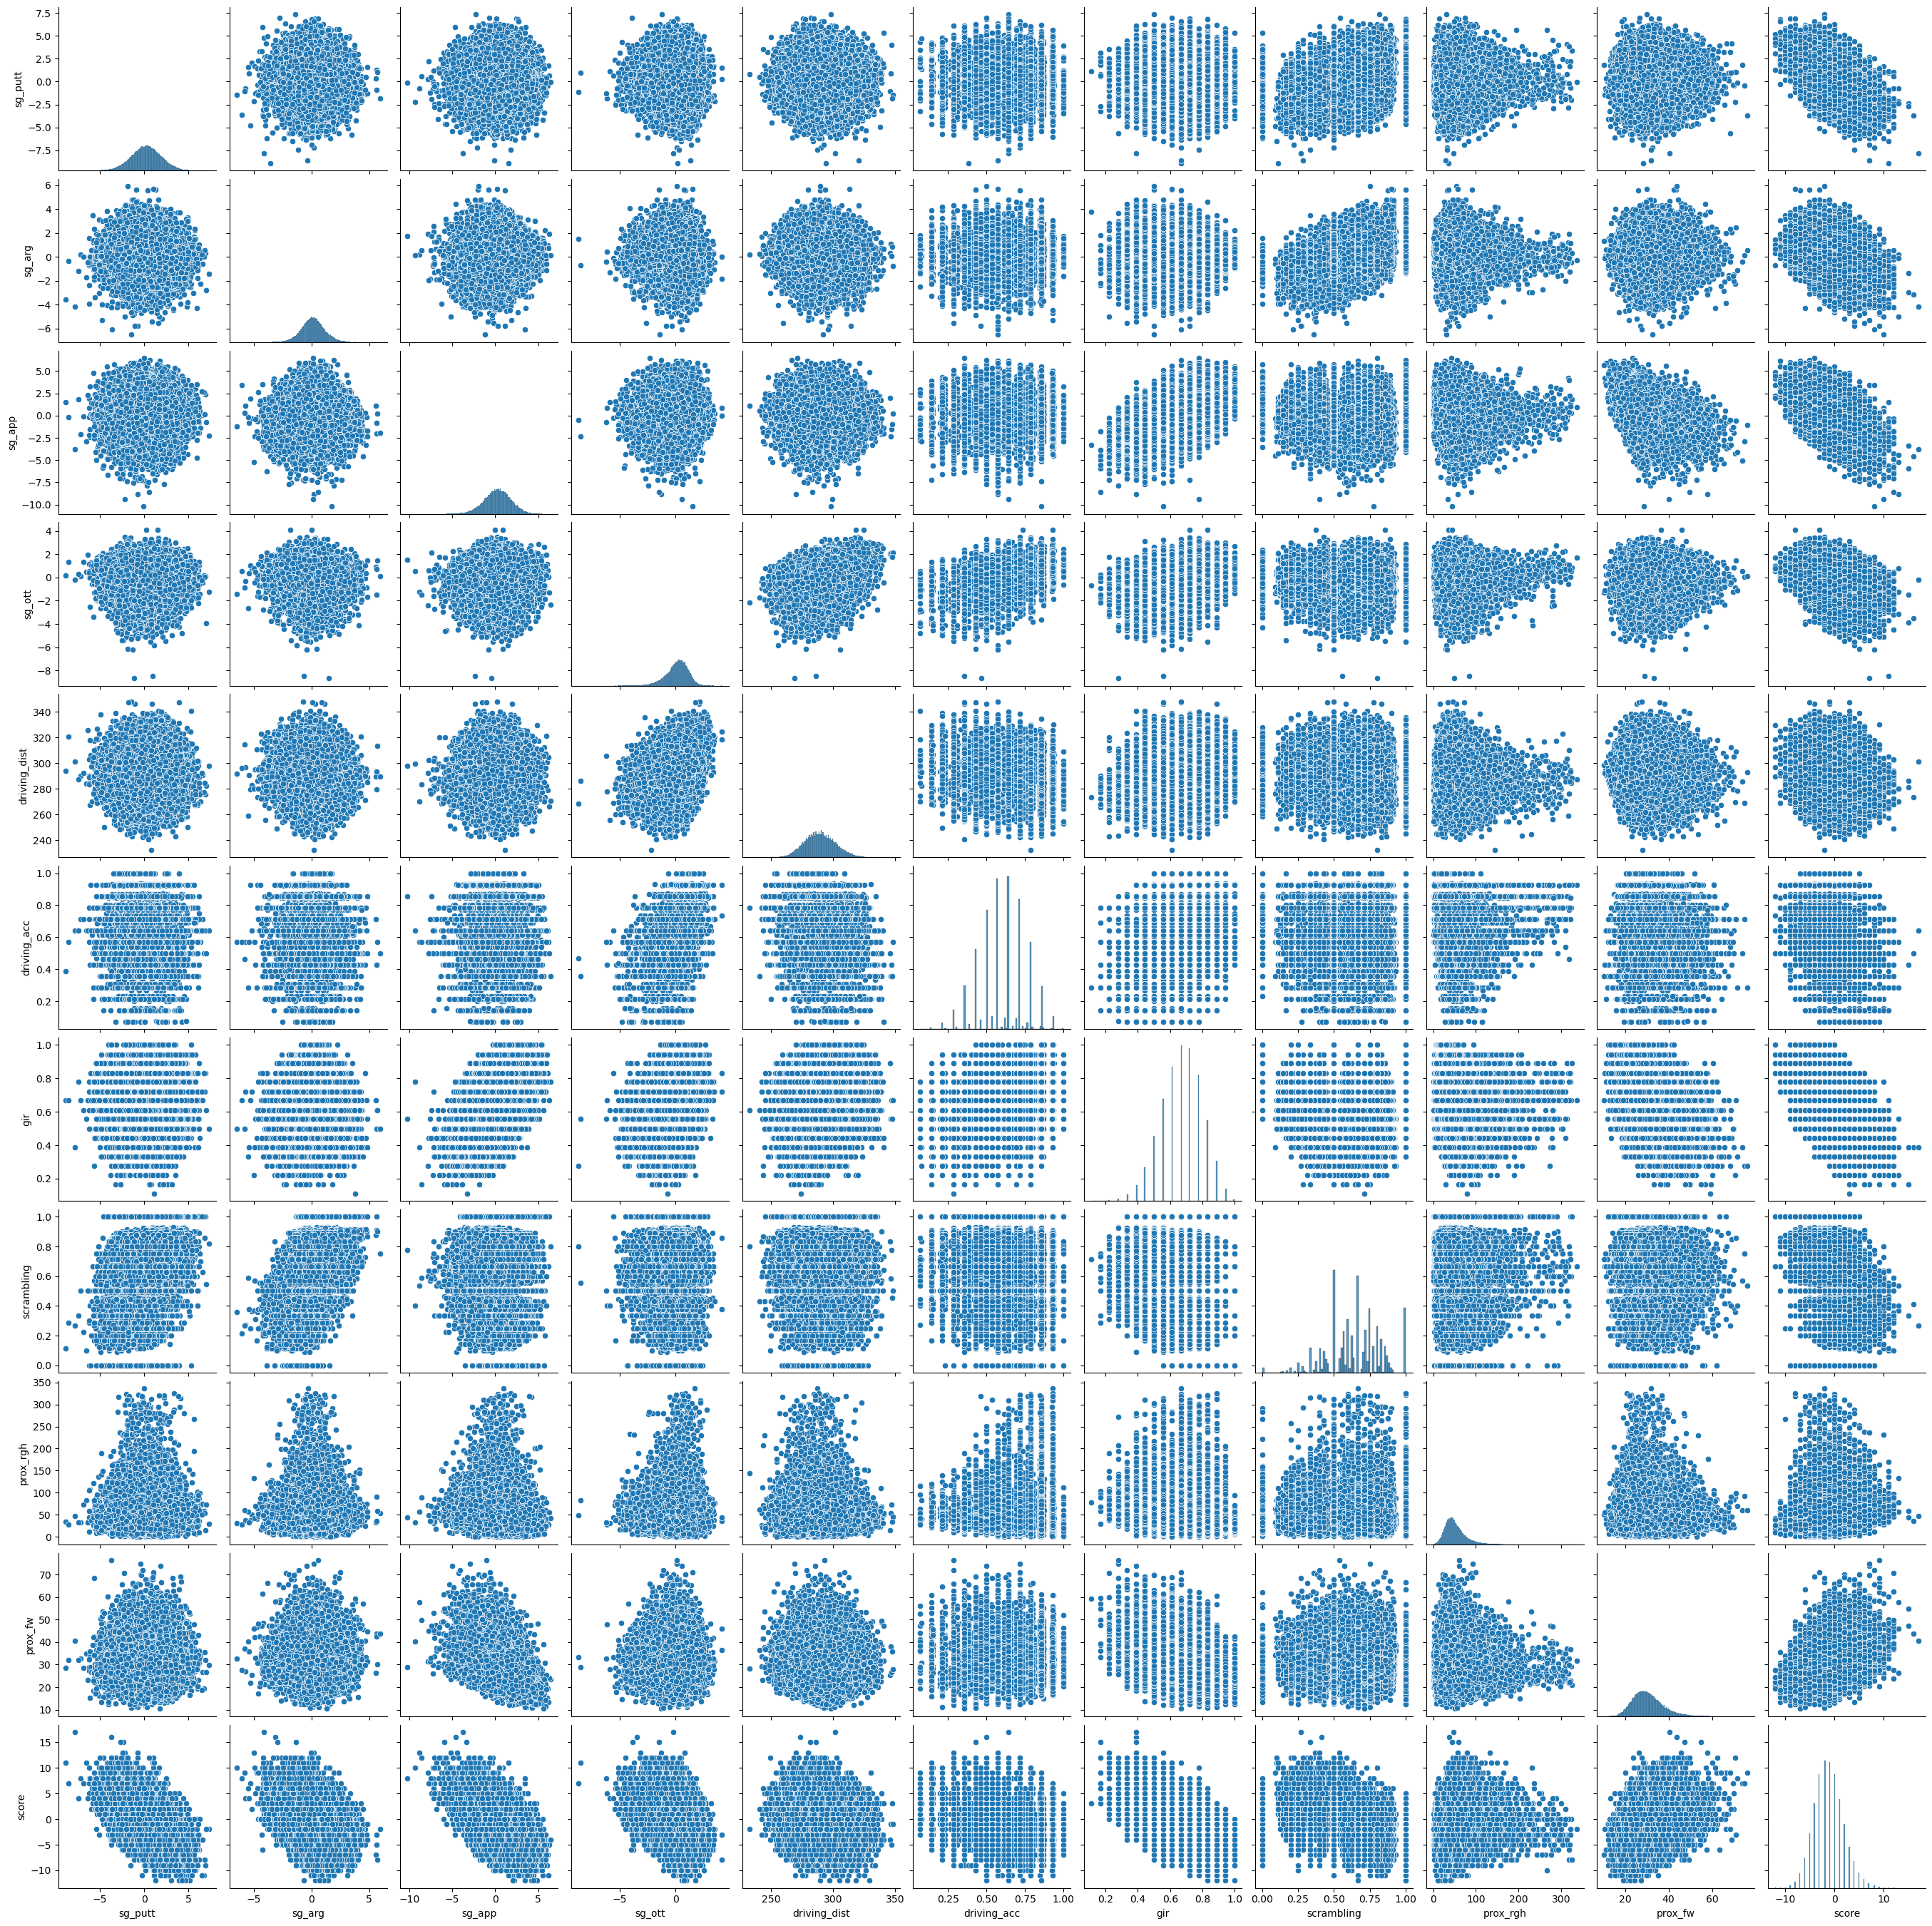

In [609]:
features = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 
            'driving_dist', 'driving_acc', 'gir', 'scrambling', 
            'prox_rgh', 'prox_fw', 'score']

study = finished[features]

sns.pairplot(study)

<Axes: >

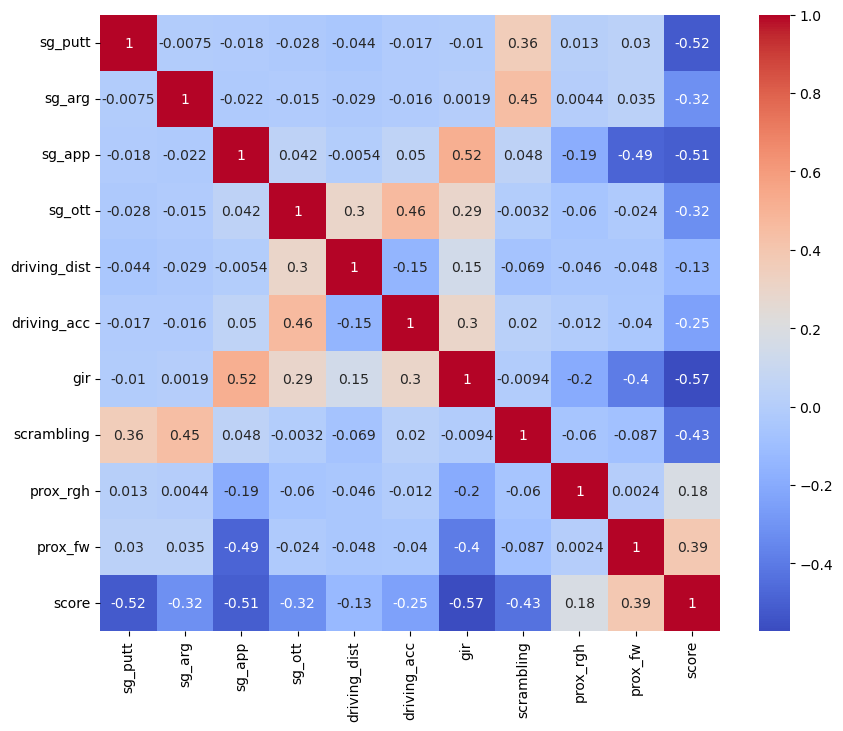

In [611]:
# Create a correlation matrix
correlation_matrix = study.corr()

# Create a heatmap with adjusted figure sizing
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Regression Models

We start with a regression approach to the data, using features from the previous round in the event samples to predict the score relative to par in the next. However, we suspect from our exploratory analysis that a regression analysis may tend to overfit the data as the distributions of scores relative to the available features are pretty spread out. In addition many of these features above are collected in the same round, so we will first perform a regression to demonstrate how that can lead to inflated performance numbers.

## Regularized Regression

In [546]:
features = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 
            'driving_dist', 'driving_acc', 'gir', 'scrambling', 
            'prox_rgh', 'prox_fw']

X = finished[features]
y = finished['score'].values.reshape(-1,1)


# Normalize data
X_norm = StandardScaler().fit_transform(X)
y_norm = StandardScaler().fit_transform(y)

X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=123)


# Define the hyperparameters to tune
param_grid = {'alpha': np.logspace(-6, 2, 20)}

# Perform grid search to find the best hyperparameters
lasso_1 = GridSearchCV(Lasso(max_iter=10000), param_grid, cv=5, n_jobs=-1)
lasso_1.fit(X_norm_train, y_norm_train)

print(f'Cross-validated training score: {lasso_1.best_score_.mean():.5f}')

# Get the best hyperparameters and the best model
best_alpha = lasso_1.best_params_['alpha']
best_lasso_1 = lasso_1.best_estimator_

# Evaluate the best model on the test data
test_score = best_lasso_1.score(X_norm_test, y_norm_test)

# Print the best hyperparameters and the test score
print("Best alpha:", best_alpha)
print(f"Test score: {test_score:.5f}")

# Get the coefficients of the best model
coefficients = best_lasso_1.coef_.reshape(-1,1)

# Get the standard errors of the coefficients
std_errors = np.sqrt(np.diagonal(np.linalg.inv(X_norm_train.T @ X_norm_train) * np.mean(np.square(y_norm_train - X_norm_train @ coefficients), axis=0))).reshape(-1,1)

# Calculate the t-stats and p-values
t_stats = coefficients / std_errors
p_values = 2 * (1 - t.cdf(np.abs(t_stats), df=X_norm_train.shape[0] - X_norm_train.shape[1]))

# Create a DataFrame to summarize the coefficients, t-stats, p-values, and standard errors
summary_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients.flatten(),
                            'Std Error': std_errors.flatten(), 'T-Stat': t_stats.flatten(), 'P-Value': p_values.flatten()})


# Print the summary
print(summary_df)

summary_df.to_latex('reg_1.tex', index=False)

Cross-validated training score: 0.85458
Best alpha: 1.8329807108324375e-05
Test score: 0.85991
        Feature  Coefficient  Std Error      T-Stat  P-Value
0       sg_putt    -0.514393   0.001815 -283.488189      0.0
1        sg_arg    -0.296814   0.001894 -156.745432      0.0
2        sg_app    -0.279275   0.002111 -132.266717      0.0
3        sg_ott    -0.177980   0.002052  -86.717050      0.0
4  driving_dist    -0.076985   0.001868  -41.214840      0.0
5   driving_acc    -0.086562   0.002042  -42.398487      0.0
6           gir    -0.270869   0.002179 -124.328499      0.0
7    scrambling    -0.089405   0.002055  -43.506919      0.0
8      prox_rgh     0.063205   0.001715   36.853366      0.0
9       prox_fw     0.150200   0.001963   76.496437      0.0


/var/folders/c2/fhzf9hbn7rgflq5r2ss9_qr80000gn/T/ipykernel_50060/75444356.py:54: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  summary_df.to_latex('reg_1.tex', index=False)


## Controlling for Bias

We have concerns that since these statistics are calculated from that round's performance that they may not be completely exogenous. So instead we will use a lagged regression to predict performance. Also questions about normalization since sg categories are already calculated wrt. the PGA Tour baseline from that distance.

In [547]:
selected = finished[['year','event_id','dg_id', 'course_num', 'round_num', 'score'] + features]

selected = selected.groupby(['year', 'event_id', 'dg_id']).filter(lambda x: len(x) >= 2)
selected = selected.sort_values('round_num', ascending=True)

l1_features = []
for var in features:
    selected[f'{var}_l1'] = selected.groupby(['year', 'event_id', 'dg_id'])[var].shift(1)
    l1_features.append(f'{var}_l1')

selected = selected.dropna(subset=['sg_putt_l1'])

selected.head()

year  event_id  dg_id  course_num  round_num  score  sg_putt  sg_arg  \
414    2020         6   6930           6          2   -4.0    2.625   0.231   
10253  2019        34   7489         503          2   -6.0    1.618   1.120   
10796  2019       524  23604         876          2   -2.0    0.072  -0.065   
3702   2023         9  10104           9          2    2.0    0.268   1.655   
5598   2022        41  14967         770          2   -2.0    2.898  -1.413   

       sg_app  sg_ott  ...  sg_putt_l1  sg_arg_l1  sg_app_l1  sg_ott_l1  \
414     0.982   0.421  ...      -1.463     -0.945     -0.466     -0.132   
10253   2.491   0.386  ...      -1.964     -1.216      3.604      0.928   
10796  -0.827   1.436  ...       0.738      0.610     -0.221      0.578   
3702   -3.191   0.743  ...       0.111     -0.400      0.191      0.281   
5598    1.033  -0.483  ...       0.289      0.141     -0.776      1.164   

       driving_dist_l1  driving_acc_l1  gir_l1  scrambling_l1  prox_rgh_l1  \
414              276.4           0.571   0.611          0.375       35.834   
10253            257.7           0.857   0.833          0.333       14.789   
10796            302.6           0.571   0.722          1.000       25.687   
3702             279.3           0.571   0.667          0.500       46.490   
5598             303.8           0.500   0.667          0.500       51.043   

       prox_fw_l1  
414        39.047  
10253      24.324  
10796      25.689  
3702       42.718  
5598       32.908  

[5 rows x 26 columns]

In [548]:
X = selected[l1_features]
y = selected['score'].values.reshape(-1, 1)

# Normalize data
X_norm = StandardScaler().fit_transform(X)
y_norm = StandardScaler().fit_transform(y)

X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=123)

# Define the hyperparameters to tune
param_grid = {'alpha': np.logspace(-6, 2, 20)}

# Perform grid search to find the best hyperparameters
lasso = GridSearchCV(Lasso(max_iter=10000), param_grid, cv=5, n_jobs=-1)
lasso.fit(X_norm_train, y_norm_train)

print(f'Cross-validated training score: {lasso.best_score_.mean():.5f}')

# Get the best hyperparameters and the best model
best_alpha = lasso.best_params_['alpha']
best_model = lasso.best_estimator_

# Evaluate the best model on the test data
test_score = best_model.score(X_norm_test, y_norm_test)

# Print the best hyperparameters and the test score
print("Best alpha:", best_alpha)
print(f"Test score: {test_score:.5f}")

# Get the coefficients of the best model
coefficients = best_model.coef_.reshape(-1,1)

# Get the standard errors of the coefficients
std_errors = np.sqrt(np.diagonal(np.linalg.inv(X_norm_train.T @ X_norm_train) * np.mean(np.square(y_norm_train - X_norm_train @ coefficients), axis=0))).reshape(-1,1)

# Calculate the t-stats and p-values
t_stats = coefficients / std_errors
p_values = 2 * (1 - t.cdf(np.abs(t_stats), df=X_norm_train.shape[0] - X_norm_train.shape[1]))

# Create a DataFrame to summarize the coefficients, t-stats, p-values, and standard errors
summary_df = pd.DataFrame({'Feature': l1_features, 'Coefficient': coefficients.flatten(),
                            'Std Error': std_errors.flatten(), 'T-Stat': t_stats.flatten(), 'P-Value': p_values.flatten()})

# Print the summary
print(summary_df)

summary_df.to_latex('reg_2.tex', index=False)

Cross-validated training score: 0.05905
Best alpha: 1e-06
Test score: 0.05963
           Feature  Coefficient  Std Error     T-Stat       P-Value
0       sg_putt_l1     0.041162   0.005384   7.645239  2.131628e-14
1        sg_arg_l1     0.038191   0.005610   6.807616  1.006617e-11
2        sg_app_l1     0.154981   0.006278  24.687861  0.000000e+00
3        sg_ott_l1     0.059452   0.006150   9.666309  0.000000e+00
4  driving_dist_l1    -0.097855   0.005557 -17.609018  0.000000e+00
5   driving_acc_l1    -0.045770   0.006075  -7.534283  5.018208e-14
6           gir_l1    -0.196880   0.006422 -30.656151  0.000000e+00
7    scrambling_l1    -0.047641   0.006057  -7.865313  3.774758e-15
8      prox_rgh_l1     0.047310   0.005102   9.273439  0.000000e+00
9       prox_fw_l1     0.090193   0.005823  15.489560  0.000000e+00


/var/folders/c2/fhzf9hbn7rgflq5r2ss9_qr80000gn/T/ipykernel_50060/552586129.py:47: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  summary_df.to_latex('reg_2.tex', index=False)


We observe as we suspected poor performance using features from the previous round on scoring, but we continue attempting a few more regularized tree models to see if we can improve performance. In addition, while we expect the tree models to not be able to improve the performance by a significant amount, we can glean some information about the importances of each feature relative to the others used in the model.

## Pruned Decision Tree Regression

Best ccp_alpha: 0.006197361902491733
Cross validated training score: 0.07178
Test score: 0.06885


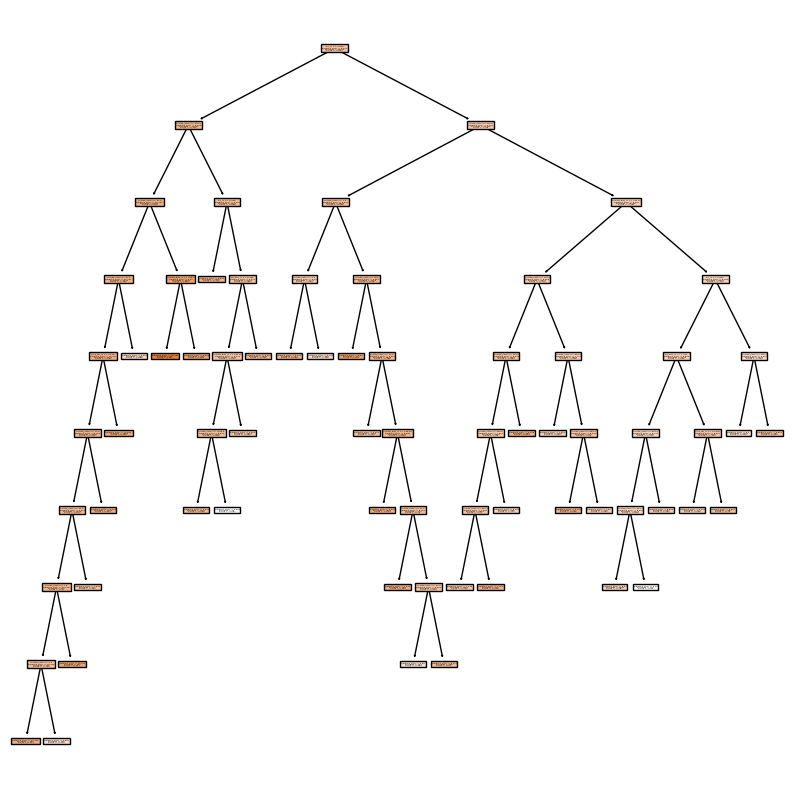

In [549]:
# Define the features and target variable
X = np.hstack((X, selected['course_num'].values.reshape(-1,1)))
l1_features.append('course_num')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Create an instance of the DecisionTreeRegressor
tree = DTR()

# Fit the decision tree regressor to the data
tree.fit(X_train, y_train)

# Perform cost complexity pruning
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]

# Perform grid search to find the best hyperparameters
pruned = RandomizedSearchCV(tree, {'ccp_alpha': ccp_alphas}, cv=5, n_iter=1000, 
                            n_jobs=-1, random_state=123)
pruned.fit(X_train, y_train)

# Get the best hyperparameters and the best model
best_ccp_alpha = pruned.best_params_['ccp_alpha']
best = pruned.best_estimator_

print("Best ccp_alpha:", best_ccp_alpha)
print(f"Cross validated training score: {pruned.best_score_.mean():.5f}")

test_score = best.score(X_test, y_test)
print(f"Test score: {test_score:.5f}")

# Plot the decision tree
plt.figure(figsize=(10, 10))
plot_tree(best, feature_names=l1_features, filled=True)
plt.show()

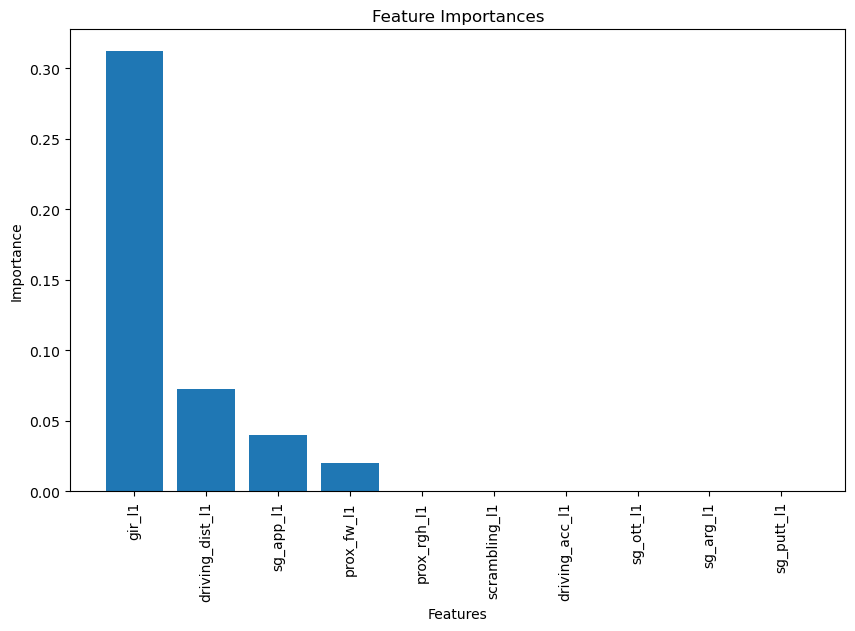

In [550]:
# Get the feature importances from the trained decision tree model
importances = best.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1][1:]

# Now the rest of your code should work
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)-1), importances[indices])
plt.xticks(range(len(importances)-1), np.array(l1_features)[indices.astype(int)], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

## Gradient Boosting Regression

In [551]:
# Create an instance of the GradientBoostingRegressor
boosting_tree = GBR(n_estimators=1000,
                    learning_rate=0.001,
                    max_depth=None,
                    random_state=123)

param_grid = {'max_depth': range(2,9)}

# Hyperparameter tuning
model = GridSearchCV(boosting_tree, param_grid, cv=5, n_jobs=-1)
model.fit(X_train, y_train.ravel())

# Get the best hyperparameters and the best model
best_depth = model.best_params_['max_depth']
best = model.best_estimator_

print("Best max depth:", best_depth)
print(f"Cross validated training score: {model.best_score_.mean():.5f}")

test_score = best.score(X_test, y_test.ravel())
print(f"Test score: {test_score:.5f}")

Best max depth: 8
Cross validated training score: 0.08121
Test score: 0.08658


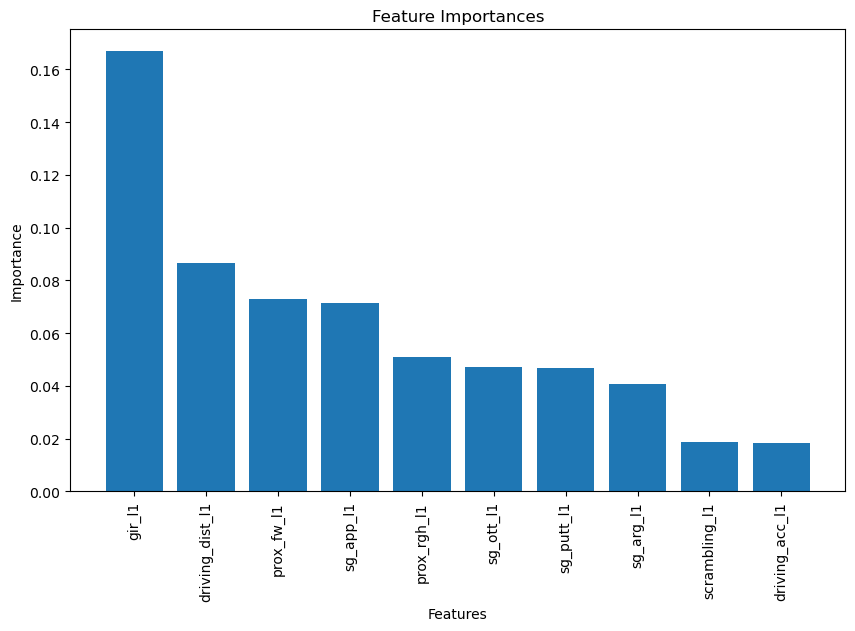

In [552]:
# Get the feature importances from the trained decision tree model
importances = best.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1][1:]

# Now the rest of your code should work
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)-1), importances[indices])
plt.xticks(range(len(importances)-1), np.array(l1_features)[indices.astype(int)], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

## Random Forest Regression

In [553]:
# Create an instance of the RandomForestRegressor
random_forest = RFR(n_estimators=1000, n_jobs=-1, random_state=123)

param_grid = {'max_depth': range(2,9)}

# Hyperparameter tuning
model = GridSearchCV(random_forest, param_grid, cv=5, n_jobs=-1)
model.fit(X_train, y_train.ravel())

# Get the best hyperparameters and the best model
best_depth = model.best_params_['max_depth']
best = model.best_estimator_

print("Best max depth:", best_depth)
print(f"Cross validated training score: {model.best_score_.mean():.5f}")

test_score = best.score(X_test, y_test.ravel())
print(f"Test score: {test_score:.5f}")

Best max depth: 8
Cross validated training score: 0.08836
Test score: 0.09394


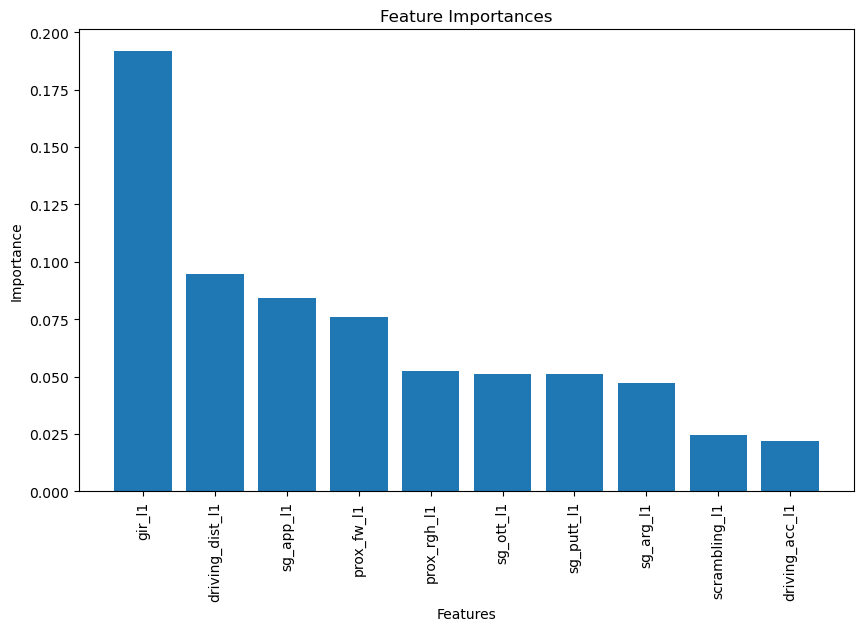

In [554]:
# Get the feature importances from the trained decision tree model
importances = best.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1][1:]

# Now the rest of your code should work
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)-1), importances[indices])
plt.xticks(range(len(importances)-1), np.array(l1_features)[indices.astype(int)], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

The models above seem to suggest that the greens in regulation percentage from the previous round is the most important feature in predicting the next rounds score. However, the parameters arrived at after parameter tuning are always at the extremes of the ranges provided and the performance is always weak, suggesting that regression tends to overfit the data a lot. Thus, we cannot be confident in these results so we must take a step back and approach this analysis from a different angle.

# Probabilistic Modeling

We elect now to study the data in a classification setting as that might help some of the overfitting issues we observed in the regression setting. To do so we generate a binary feature that =1 if the player finished in the top 20 in that event. In order to avoid any potential bias in our analysis, we only include samples in which there is recorded data for all four rounds, by each player, event, and season.

## Preprocessing

In [555]:
finished['fin_text'] = finished['fin_text'].str.replace('T', '')

finished['top_20'] = np.where(finished['fin_text'].astype(int) <= 20, 1, 0)

filtered = finished.groupby(['year', 'event_id', 'dg_id']).filter(lambda x: len(x) == 4).copy(deep=True)

averaged_data = filtered.groupby(['year','event_id', 'dg_id']).agg({'sg_putt': 'mean', 
                                                                    'sg_arg': 'mean', 
                                                                    'sg_app': 'mean', 
                                                                    'sg_ott': 'mean', 
                                                                    'driving_dist': 'mean',
                                                                    'gir': 'mean', 
                                                                    'top_20': 'mean',
                                                                    'driving_acc': 'mean',
                                                                    'scrambling': 'mean', 
                                                                    'prox_rgh': 'mean', 
                                                                    'prox_fw': 'mean', 
                                                                    'great_shots': 'sum', 
                                                                    'poor_shots': 'sum'})

averaged_data = averaged_data.sort_values('year', ascending=True).reset_index()

l1_features = []
for var in features:
    averaged_data[f'{var}_l1'] = averaged_data.groupby(['year', 'dg_id'])[var].shift(1)
    l1_features.append(f'{var}_l1')

averaged_data = averaged_data.dropna(subset=['sg_putt_l1'])

averaged_data.head()

year  event_id  dg_id  sg_putt   sg_arg   sg_app   sg_ott  driving_dist  \
68  2017        41  18695  1.96075  1.57550 -1.54750 -0.90725       292.775   
72  2017        41  17536  0.14325 -0.08725  0.04650  0.22900       286.775   
74  2017        41  16602 -0.02550 -0.66150  1.41500 -0.14600       297.125   
78  2017        41  15575 -0.61775 -0.36000  0.86325  0.19625       285.025   
83  2017        41  14606  0.22450  0.23425  0.79550  0.32775       275.575   

        gir  top_20  ...  sg_putt_l1  sg_arg_l1  sg_app_l1  sg_ott_l1  \
68  0.50000     0.0  ...     0.28200   -0.32875    0.12975    0.63775   
72  0.59725     0.0  ...    -0.29175    0.19500    1.95025    0.11675   
74  0.61125     0.0  ...     0.62400    0.62050   -1.28150   -0.24250   
78  0.62500     0.0  ...     0.82925   -0.05275    1.35550    0.08775   
83  0.63900     0.0  ...     1.06075   -0.72625   -0.73200    0.36775   

    driving_dist_l1  driving_acc_l1   gir_l1  scrambling_l1  prox_rgh_l1  \
68          298.325         0.53575  0.68075        0.48000     60.42825   
72          290.950         0.62500  0.80550        0.51350     43.04150   
74          294.425         0.42850  0.61125        0.57800     69.13875   
78          296.425         0.60700  0.62525        0.64400     35.40450   
83          285.475         0.64275  0.62525        0.56725     49.23350   

    prox_fw_l1  
68    39.55625  
72    29.28975  
74    39.73425  
78    32.77750  
83    38.94875  

[5 rows x 26 columns]

## Logistic Regression

In [556]:
X = averaged_data[l1_features]
y = averaged_data['top_20']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Define the range of C values to search
param_grid = {'C': np.logspace(-4, 4, 20)}

# Create a logistic regression model with L1 penalty
logreg = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000)

# Perform grid search with cross-validation
model = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
model.fit(X_train, y_train)

print(f'Cross-validated training score: {model.best_score_.mean():.5f}')

# Get the best hyperparameters and the best model
best_alpha = model.best_params_
best_logreg = model.best_estimator_

# Compute the predicted probabilities for the test data
y_pred_proba = best_logreg.predict_proba(X_test)[:, 1]

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the ROC AUC score
print(f"ROC AUC score: {roc_auc:.5f}")

# Print the best hyperparameters and the test score
print("Best alpha:", best_alpha)

# Get the coefficients of the best model
coefficients = best_logreg.coef_[0]

# Create a DataFrame to summarize the coefficients
coefficients_df = pd.DataFrame({'Feature': l1_features, 'Coefficient': coefficients})

# Print the coefficients DataFrame sorted by coefficients in descending order
coefficients_df_sorted = coefficients_df.sort_values(by='Coefficient',
                                                     key=lambda x: abs(x),
                                                     ascending=False)
print(coefficients_df_sorted)

Cross-validated training score: 0.57587
ROC AUC score: 0.58027
Best alpha: {'C': 545.5594781168514}
           Feature  Coefficient
6           gir_l1    -1.379007
5   driving_acc_l1     0.490965
7    scrambling_l1    -0.401622
2        sg_app_l1     0.214269
3        sg_ott_l1     0.185737
1        sg_arg_l1     0.125106
0       sg_putt_l1     0.084020
4  driving_dist_l1     0.019691
9       prox_fw_l1    -0.004863
8      prox_rgh_l1     0.000058


We started with a basic logistic regression model on the raw features in order to observe the performance of the model. Firstly, we observe improved performance with a cross validated ROC AUC of 0.57587, which although somewhat poor, suggests the model is learning some relationships in the data. Secondly, we observe that gir has the largest coefficient but the large regularization parameter suggests that the coefficients may not totally capture the importance of each feature because of differences in scale.

In [557]:
# Normalize data
X_norm = StandardScaler().fit_transform(X)
X_norm = pd.DataFrame(X_norm, columns=l1_features)

X_norm_train, X_norm_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=123)

# Define the range of C values to search
param_grid = {'C': np.logspace(-6, 2, 100)}

# Create a logistic regression model with L1 penalty
logreg = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000)

# Perform grid search with cross-validation
model = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
model.fit(X_norm_train, y_train)

print(f'Cross-validated training score: {model.best_score_.mean():.5f}')

# Get the best hyperparameters and the best model
best_alpha = model.best_params_
best = model.best_estimator_

# Compute the predicted probabilities for the test data
y_pred_proba = best.predict_proba(X_norm_test)[:, 1]

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the ROC AUC score
print(f"Test ROC AUC score: {roc_auc:.5f}")

# Print the best hyperparameters and the test score
print("Best alpha:", best_alpha)

# Get the coefficients of the best model
coefficients = best.coef_[0]

# Create a DataFrame to summarize the coefficients
coefficients_df = pd.DataFrame({'Feature': l1_features, 'Coefficient': coefficients})

# Print the coefficients DataFrame sorted by coefficients in descending order
coefficients_df_sorted = coefficients_df.sort_values(by='Coefficient',
                                                     key=lambda x: abs(x),
                                                     ascending=False)
print(coefficients_df_sorted)

Cross-validated training score: 0.57595
Test ROC AUC score: 0.58045
Best alpha: {'C': 0.6579332246575682}
           Feature  Coefficient
4  driving_dist_l1     0.228873
2        sg_app_l1     0.171480
6           gir_l1    -0.111432
3        sg_ott_l1     0.106819
0       sg_putt_l1     0.066989
1        sg_arg_l1     0.065689
5   driving_acc_l1     0.048863
7    scrambling_l1    -0.035010
9       prox_fw_l1    -0.017582
8      prox_rgh_l1     0.001272


After normalizing the data and refitting the model, we end up with a much improved result. We observe that the largest coefficient is now on driving distance and that the regularization parameter is now a reasonable number. We still note that the performance cannot break into the range of >0.6 ROC AUC, which would be fair performance.

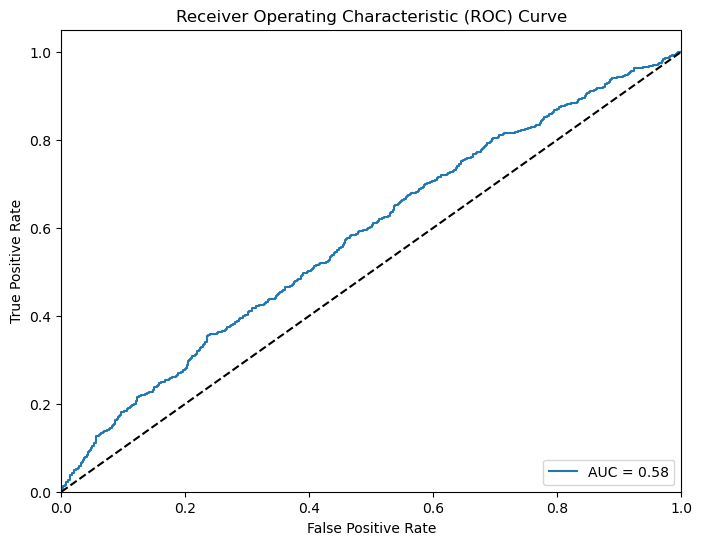

In [558]:
# Compute the false positive rate, true positive rate, and thresholds
logit_fpr, logit_tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the area under the ROC curve
logit_roc_auc = auc(logit_fpr, logit_tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(logit_fpr, logit_tpr, label=f'AUC = {logit_roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [559]:
# Compute optimal decision threshold
# from sklearn documentation:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
boundaries = []
scores = []

for train, test in cv.split(X_norm_train, y_train):
    best.fit(X_norm_train.iloc[train], y_train.iloc[train])
    # Compute the predicted labels for the test data
    y_prob = best.predict_proba(X_norm_train.iloc[test])[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train.iloc[test], y_prob)
    dist = np.sqrt((1-tpr)**2+(fpr)**2)
    optimal_index = np.argmin(dist)
    boundaries.append(thresholds[optimal_index])

# Get the cross-validated optimal threshold and corresponding F1 score
optimal_threshold = np.mean(boundaries)

print(f"Cross validated optimal threshold (from training): {optimal_threshold:.5f}")

Cross validated optimal threshold (from training): 0.33460


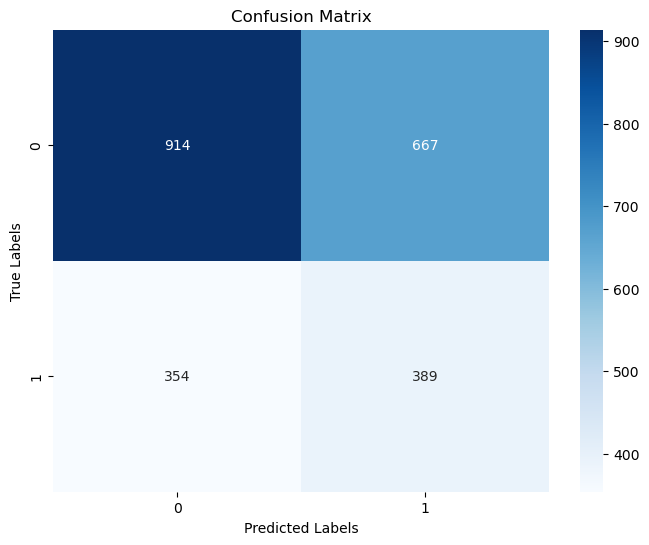

Accuracy: 0.560671256454389
Precision: 0.3683712121212121
Recall: 0.5235531628532974
F1 Score: 0.4324624791550861


In [560]:
# Compute the predicted labels for the test data
y_prob = best.predict_proba(X_norm_test)[:, 1]
y_pred = (y_prob >= optimal_threshold).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

## Decision Tree

Best ccp_alpha: 0.001178240316719037
Cross validated training score: 0.55577
Test ROC AUC score: 0.55551


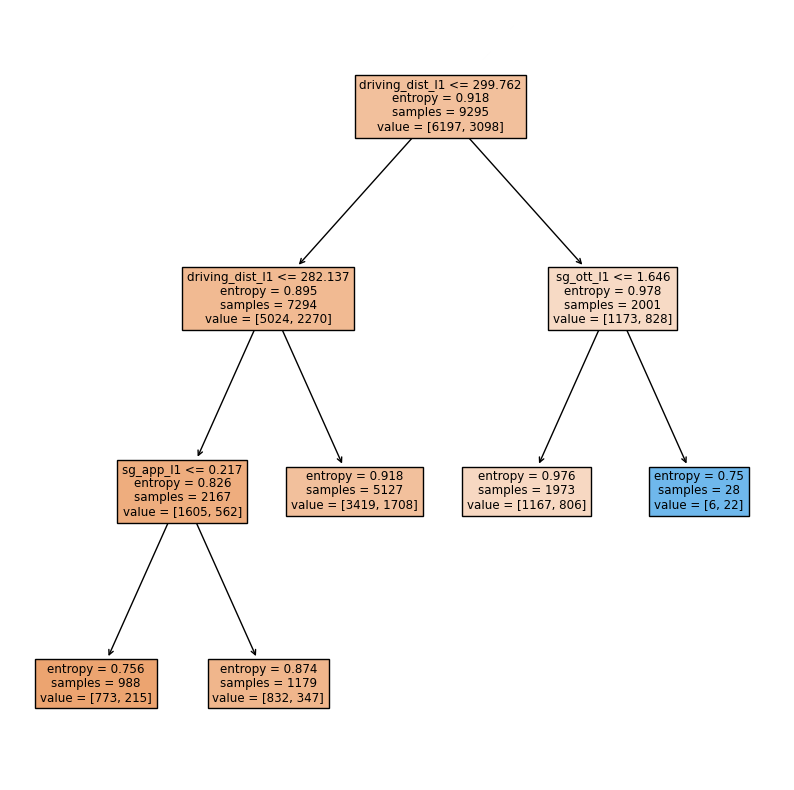

In [561]:
l1_features.append('event_id')
X = averaged_data[l1_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Create an instance of the DecisionTreeClassifier
tree = DTC(criterion='entropy')

# Fit the decision tree regressor to the data
tree.fit(X_train, y_train)

# Perform cost complexity pruning
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]

# Perform grid search to find the best hyperparameters
pruned = GridSearchCV(tree, {'ccp_alpha': ccp_alphas}, cv=5, n_jobs=-1, scoring='roc_auc')
pruned.fit(X_train, y_train)

# Get the best hyperparameters and the best model
best_ccp_alpha = pruned.best_params_['ccp_alpha']
best = pruned.best_estimator_

print("Best ccp_alpha:", best_ccp_alpha)
print(f"Cross validated training score: {pruned.best_score_.mean():.5f}")

# Compute the predicted probabilities for the test data
y_pred_proba = best.predict_proba(X_test)[:, 1]

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the ROC AUC score
print(f"Test ROC AUC score: {roc_auc:.5f}")

# Plot the decision tree
plt.figure(figsize=(10, 10))
plot_tree(best, feature_names=l1_features, filled=True)
plt.show()

In contrast to the regression tree we previously observed, the decision tree fit in the classification setting is much less complex and more interpretable. Below, we also observe that driving distance is significantly more important in determining the split values for this model.

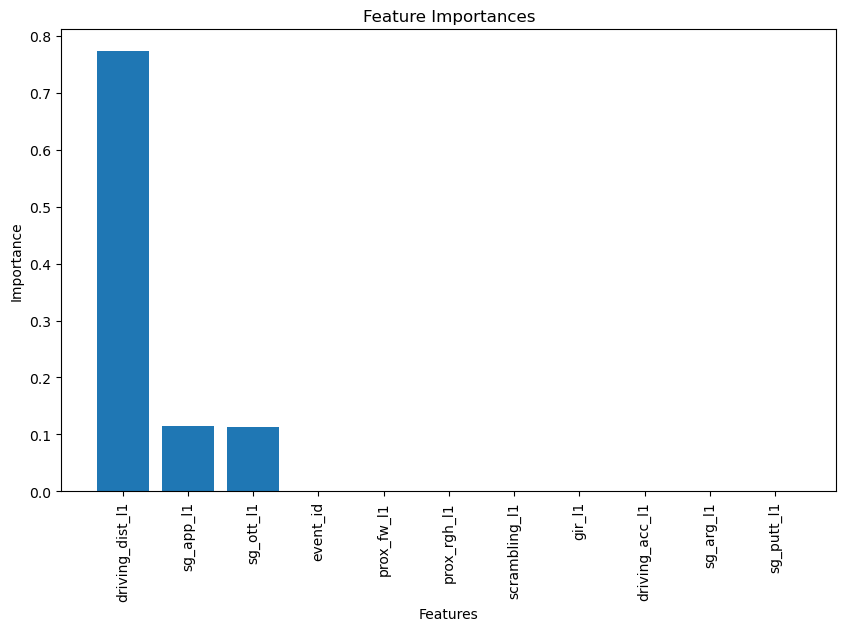

In [562]:
# Get the feature importances from the trained decision tree model
importances = best.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), np.array(l1_features)[indices.astype(int)], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

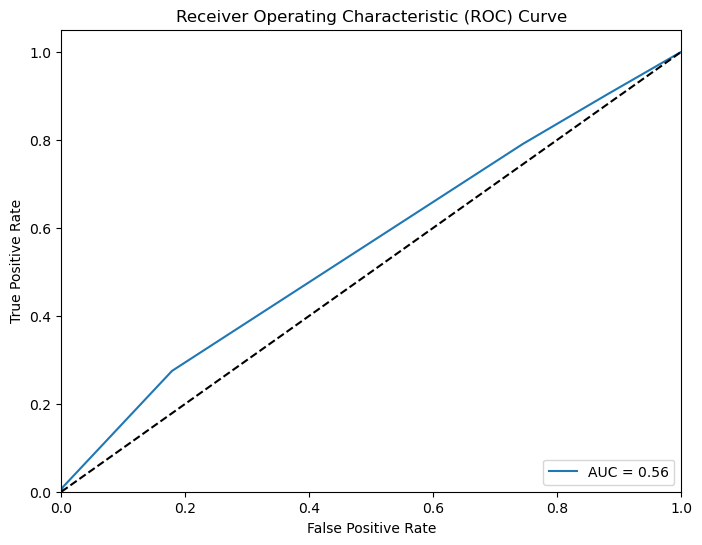

In [563]:
# Compute the false positive rate, true positive rate, and thresholds
dtc_fpr, dtc_tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the area under the ROC curve
dtc_roc_auc = auc(dtc_fpr, dtc_tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(dtc_fpr, dtc_tpr, label=f'AUC = {dtc_roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [564]:
# Compute optimal decision threshold
# from sklearn documentation:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
boundaries = []
scores = []

for train, test in cv.split(X_train, y_train):
    best.fit(X_train.iloc[train], y_train.iloc[train])
    # Compute the predicted labels for the test data
    y_prob = best.predict_proba(X_train.iloc[test])[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train.iloc[test], y_prob)
    dist = np.sqrt((1-tpr)**2+(fpr)**2)
    optimal_index = np.argmin(dist)
    boundaries.append(thresholds[optimal_index])

# Get the cross-validated optimal threshold and corresponding F1 score
optimal_threshold = np.mean(boundaries)

print(f"Cross validated optimal threshold (from training): {optimal_threshold:.5f}")

Cross validated optimal threshold (from training): 0.35919


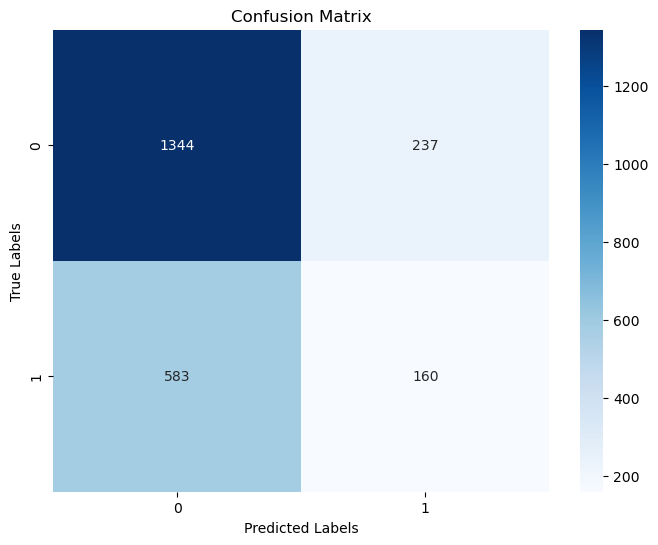

Accuracy: 0.6471600688468159
Precision: 0.40302267002518893
Recall: 0.21534320323014805
F1 Score: 0.2807017543859649


In [565]:
# Compute the predicted labels for the test data
y_prob = best.predict_proba(X_test)[:,1]
y_pred = (y_prob >= optimal_threshold).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

## Gradient Boosting Classifier

In [566]:
# Create an instance of the GradientBoostingClassifier
boosting_tree = GBC(n_estimators=1000,
                    learning_rate=0.001,
                    max_depth=None,
                    random_state=123)

param_grid = {'max_leaf_nodes': range(8,12,2)}

# Hyperparameter tuning
model = GridSearchCV(boosting_tree, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
model.fit(X_train, y_train)

# Get the best hyperparameters and the best model
best_nodes = model.best_params_['max_leaf_nodes']
best = model.best_estimator_

print("Best number of terminal nodes:", best_nodes)
print(f"Cross validated training score: {model.best_score_.mean():.5f}")

# Compute the predicted probabilities for the test data
y_pred_proba = best.predict_proba(X_test)[:, 1]

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the ROC AUC score
print(f"Test ROC AUC: {roc_auc:.5f}")

Best number of terminal nodes: 8
Cross validated training score: 0.57383
Test ROC AUC: 0.57661


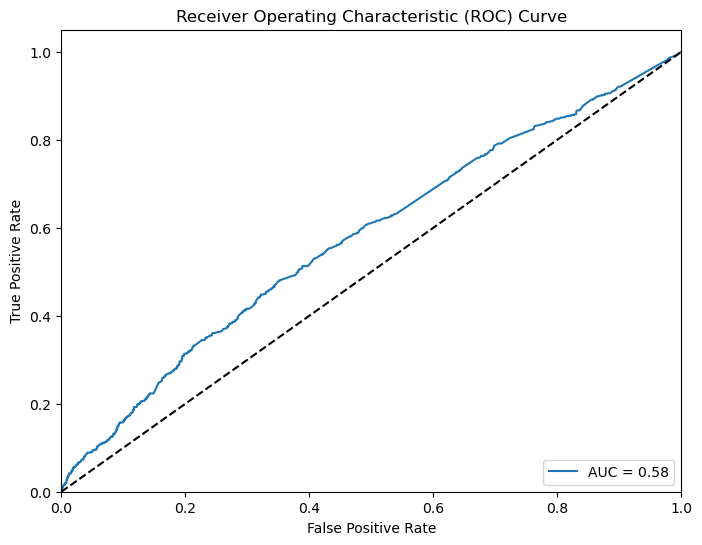

In [567]:
# Compute the false positive rate, true positive rate, and thresholds
gbc_fpr, gbc_tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the area under the ROC curve
gbc_roc_auc = auc(gbc_fpr, gbc_tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(gbc_fpr, gbc_tpr, label=f'AUC = {gbc_roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [568]:
# Compute optimal decision threshold
# from sklearn documentation:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
boundaries = []
scores = []

for train, test in cv.split(X_train, y_train):
    best.fit(X_train.iloc[train], y_train.iloc[train])
    # Compute the predicted labels for the test data
    y_prob = best.predict_proba(X_train.iloc[test])[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train.iloc[test], y_prob)
    dist = np.sqrt((1-tpr)**2+(fpr)**2)
    optimal_index = np.argmin(dist)
    boundaries.append(thresholds[optimal_index])

# Get the cross-validated optimal threshold and corresponding F1 score
optimal_threshold = np.mean(boundaries)

print(f"Cross validated optimal threshold (from training): {optimal_threshold:.5f}")

Cross validated optimal threshold (from training): 0.33103


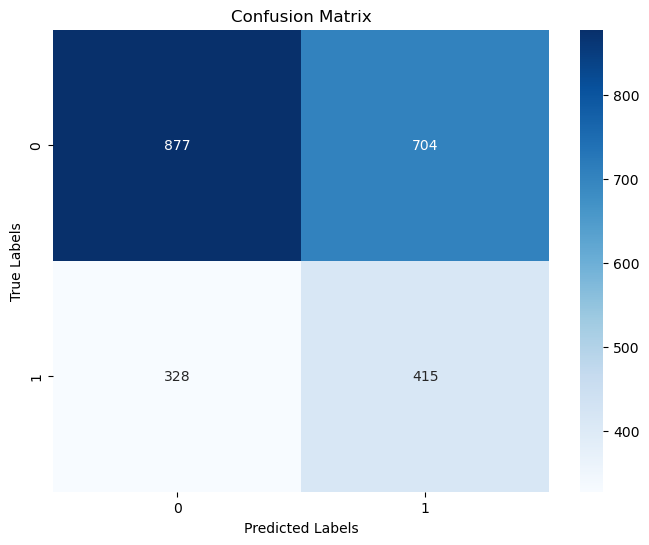

Accuracy: 0.5559380378657487
Precision: 0.3708668453976765
Recall: 0.5585464333781965
F1 Score: 0.44575725026852847


In [569]:
# Compute the predicted labels for the test data
y_prob = best.predict_proba(X_test)[:,1]
y_pred = (y_prob >= optimal_threshold).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

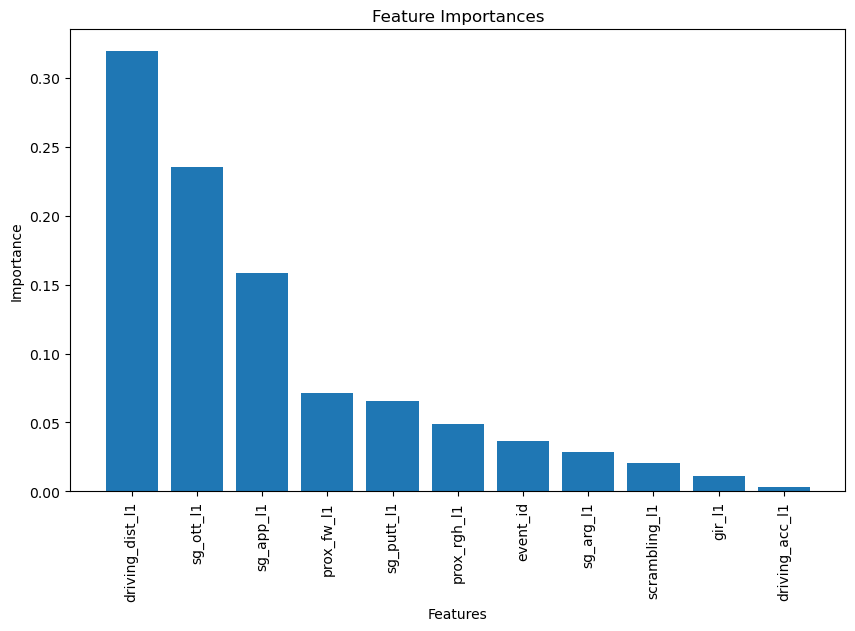

In [570]:
# Get the feature importances from the trained decision tree model
importances = best.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), np.array(l1_features)[indices.astype(int)], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

## Random Forest Classifier

In [571]:
# Create an instance of the RandomForestClassifier
random_forest = RFC(n_estimators=1000, criterion='entropy', 
                    n_jobs=-1, random_state=123)

param_grid = {'max_leaf_nodes': range(8,33,2)}

# Regularize by number of terminal nodes
model = GridSearchCV(random_forest, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
model.fit(X_train, y_train)

# Get the best hyperparameters and the best model
best_nodes = model.best_params_['max_leaf_nodes']
best = model.best_estimator_

print("Best number of terminal nodes:", best_nodes)
print(f"Cross validated training score: {model.best_score_.mean():.5f}")

# Compute the predicted probabilities for the test data
y_pred_proba = best.predict_proba(X_test)[:, 1]

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the ROC AUC score
print(f"Test ROC AUC score: {roc_auc:.5f}")

Best number of terminal nodes: 32
Cross validated training score: 0.57619
Test ROC AUC score: 0.58064


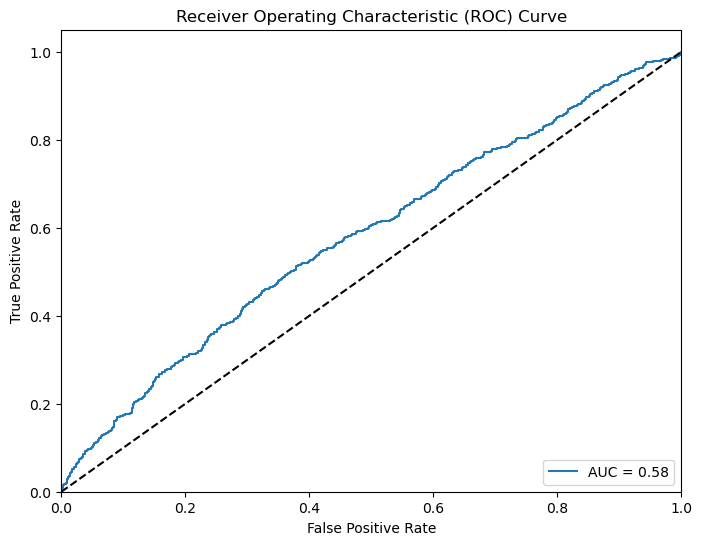

In [572]:
# Compute the false positive rate, true positive rate, and thresholds
rfc_fpr, rfc_tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the area under the ROC curve
rfc_roc_auc = auc(rfc_fpr, rfc_tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(rfc_fpr, rfc_tpr, label=f'AUC = {rfc_roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [573]:
# Compute optimal decision threshold
# from sklearn documentation:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
boundaries = []
scores = []

for train, test in cv.split(X_train, y_train):
    best.fit(X_train.iloc[train], y_train.iloc[train])
    # Compute the predicted labels for the test data
    y_prob = best.predict_proba(X_train.iloc[test])[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train.iloc[test], y_prob)
    dist = np.sqrt((1-tpr)**2+(fpr)**2)
    optimal_index = np.argmin(dist)
    boundaries.append(thresholds[optimal_index])

# Get the cross-validated optimal threshold and corresponding F1 score
optimal_threshold = np.mean(boundaries)

print(f"Cross validated optimal threshold (from training): {optimal_threshold:.5f}")

Cross validated optimal threshold (from training): 0.33093


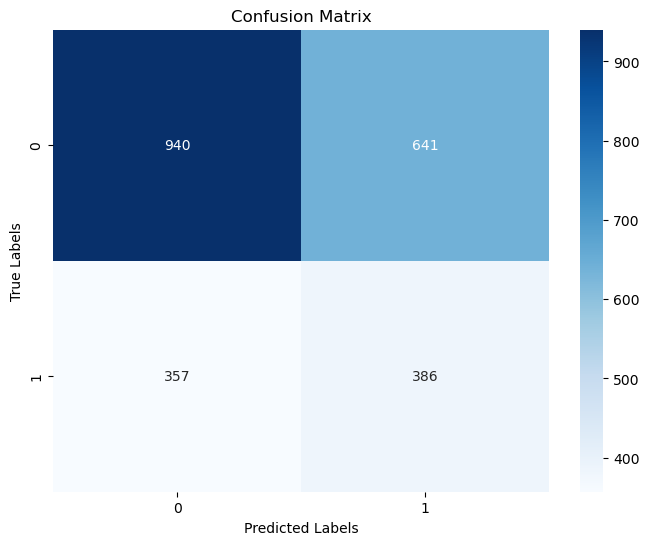

Accuracy: 0.5705679862306369
Precision: 0.3758519961051607
Recall: 0.5195154777927322
F1 Score: 0.43615819209039547


In [574]:
# Compute the predicted labels for the test data
y_prob = best.predict_proba(X_test)[:,1]
y_pred = (y_prob >= optimal_threshold).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

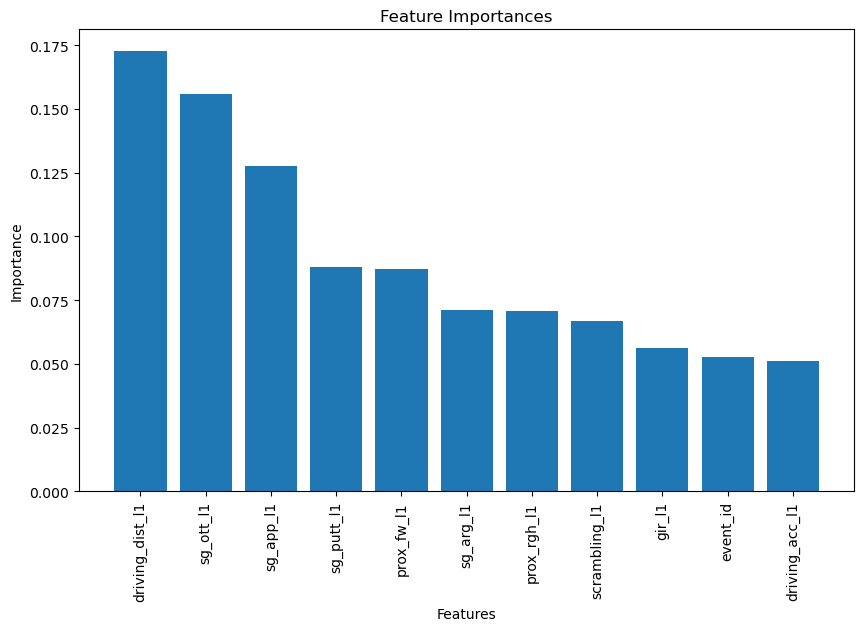

In [575]:
# Get the feature importances from the trained decision tree model
importances = best.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), np.array(l1_features)[indices.astype(int)], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

## Naive Bayes Classifier

In [576]:
# Create an instance of the GaussianNB classifier
param_grid = {'var_smoothing': np.logspace(-6, 2, 100)}
# Fit the classifier to the training data
model = GridSearchCV(GaussianNB(), param_grid, cv=5, n_jobs=-1,\
                    scoring='roc_auc')

# Fit the model to the training data
model.fit(X_norm_train, y_train)

# Get the best hyperparameters and the best model
best = model.best_estimator_

print("Best parameters:", model.best_params_)
print(f"Cross validated training ROC AUC: {model.best_score_.mean():.5f}")

# Compute the predicted probabilities for the test data
y_pred_prob = best.predict_proba(X_norm_test)[:, 1]

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Print the ROC AUC score
print(f"Test ROC AUC score: {roc_auc:.5f}")

Best parameters: {'var_smoothing': 100.0}
Cross validated training ROC AUC: 0.56679
Test ROC AUC score: 0.58136


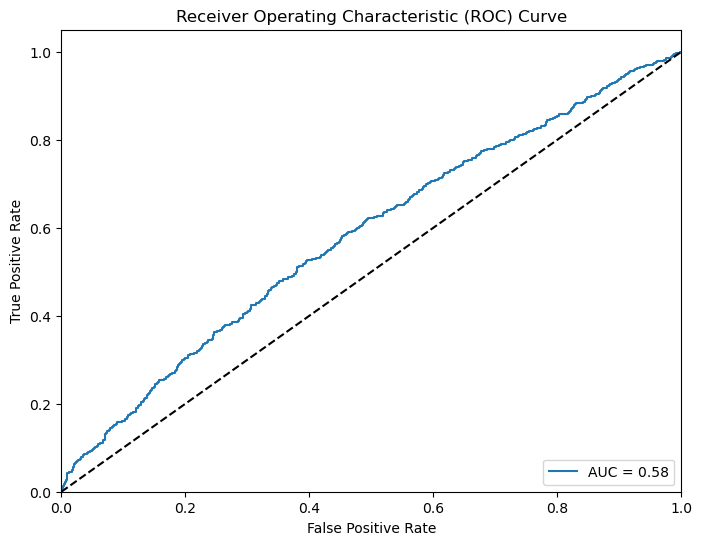

In [577]:
# Compute the false positive rate, true positive rate, and thresholds
nb_fpr, nb_tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the area under the ROC curve
nb_roc_auc = auc(nb_fpr, nb_tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(nb_fpr, nb_tpr, label=f'AUC = {nb_roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [578]:
# Compute optimal decision threshold
# from sklearn documentation:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
boundaries = []
scores = []

for train, test in cv.split(X_norm_train, y_train):
    best.fit(X_norm_train.iloc[train], y_train.iloc[train])
    # Compute the predicted labels for the test data
    y_prob = best.predict_proba(X_norm_train.iloc[test])[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train.iloc[test], y_prob)
    dist = np.sqrt((1-tpr)**2+(fpr)**2)
    optimal_index = np.argmin(dist)
    boundaries.append(thresholds[optimal_index])

# Get the cross-validated optimal threshold and corresponding F1 score
optimal_threshold = np.mean(boundaries)

print(f"Cross validated optimal threshold (from training): {optimal_threshold:.5f}")

Cross validated optimal threshold (from training): 0.33323


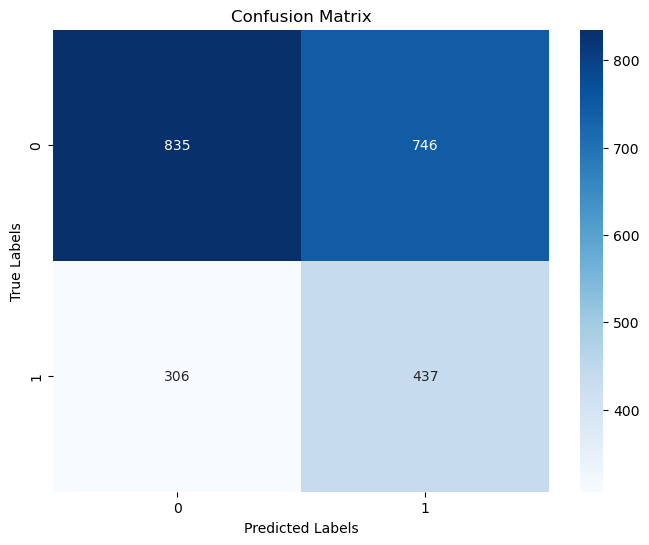

Accuracy: 0.5473321858864028
Precision: 0.3693998309382925
Recall: 0.5881561238223418
F1 Score: 0.4537902388369678


In [579]:
# Compute the predicted labels for the test data
y_prob = best.predict_proba(X_norm_test)[:,1]
y_pred = (y_prob >= optimal_threshold).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

## Comparison of ROC Curves

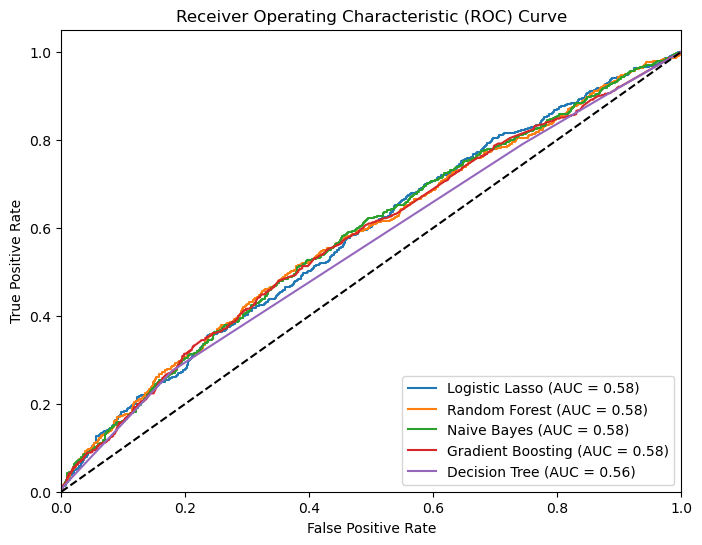

In [580]:
plt.figure(figsize=(8, 6))
plt.plot(logit_fpr, logit_tpr, label=f'Logistic Lasso (AUC = {logit_roc_auc:.2f})')
plt.plot(rfc_fpr, rfc_tpr, label=f'Random Forest (AUC = {rfc_roc_auc:.2f})')
plt.plot(nb_fpr, nb_tpr, label=f'Naive Bayes (AUC = {nb_roc_auc:.2f})')
plt.plot(gbc_fpr, gbc_tpr, label=f'Gradient Boosting (AUC = {gbc_roc_auc:.2f})')
plt.plot(dtc_fpr, dtc_tpr, label=f'Decision Tree (AUC = {dtc_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In all the above models, we observe that driving distance is the most important feature in predicting whether a player finishes in the top 20 in their next event that season relative to all the other features in all of the models. However, while we improved on our concerns about egregiously overfitting the data in the regression setting, we still observe pretty weak performance across the board pointing to some further feature engineering to improve model performance.

# Aside: Comparing Distributions of Driving Distance and Accuracy from each tournament over the years

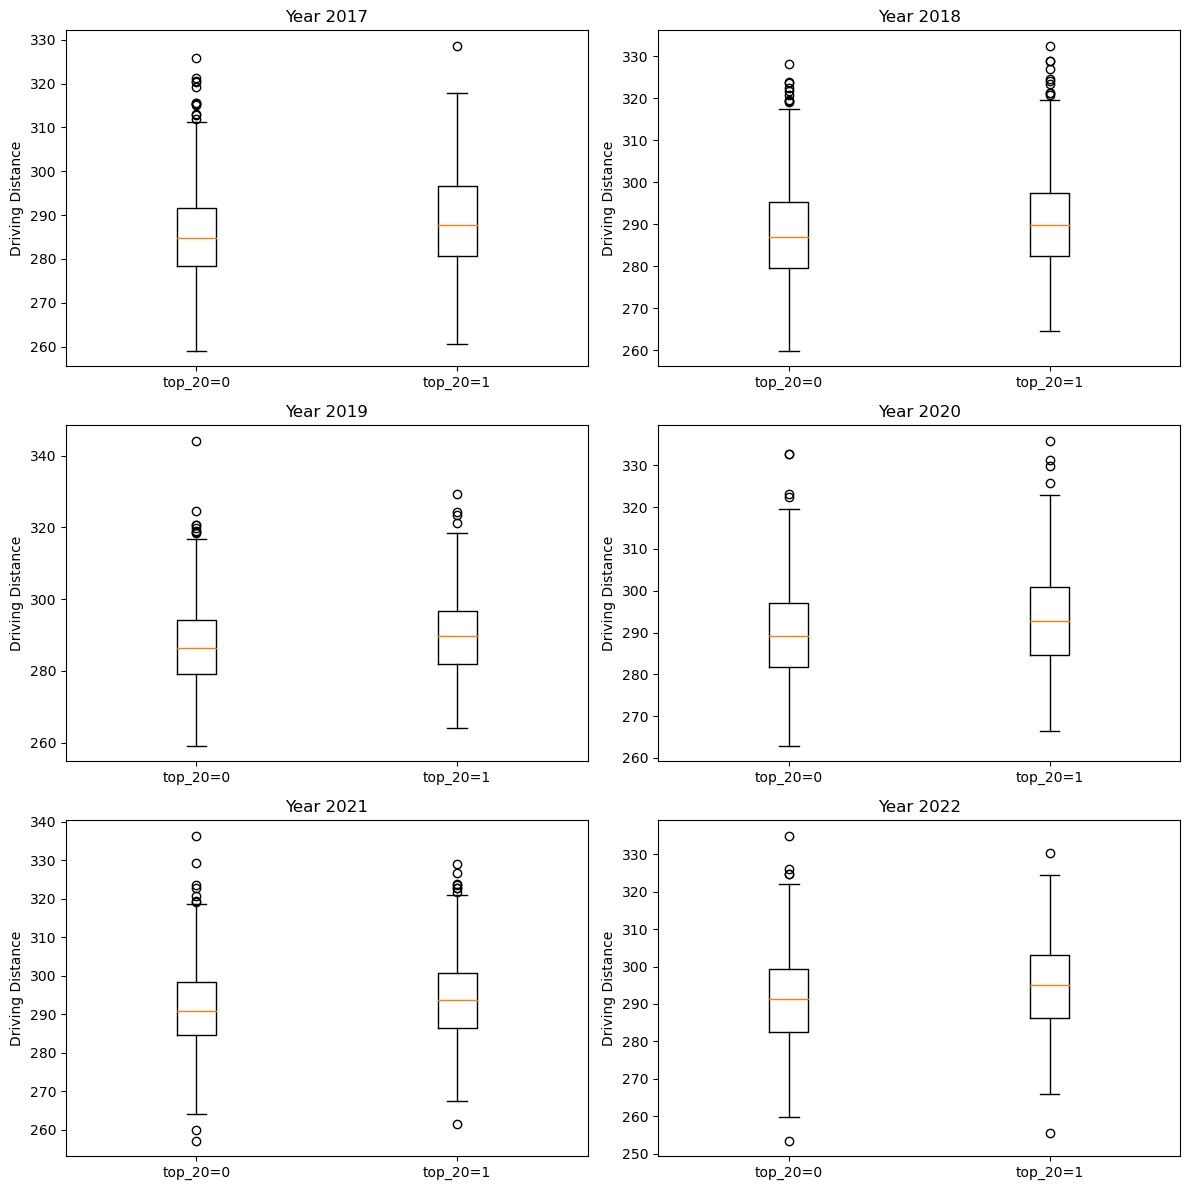

In [581]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

for year, axs in zip(np.unique(averaged_data['year'].values), axes.flatten()):
    # Get the driving distance data for top_20=0 and top_20=1 for the current year
    driving_dist_0 = averaged_data[(averaged_data['year'] == year) & (averaged_data['top_20'] == 0)]['driving_dist']
    driving_dist_1 = averaged_data[(averaged_data['year'] == year) & (averaged_data['top_20'] == 1)]['driving_dist']
    
    # Create boxplots for the current year
    axs.boxplot([driving_dist_0, driving_dist_1], labels=['top_20=0', 'top_20=1'])
    axs.set_title(f'Year {year}')
    axs.set_ylabel('Driving Distance')

# Adjust the layout of subplots
plt.tight_layout()

# Show the plot
plt.show()

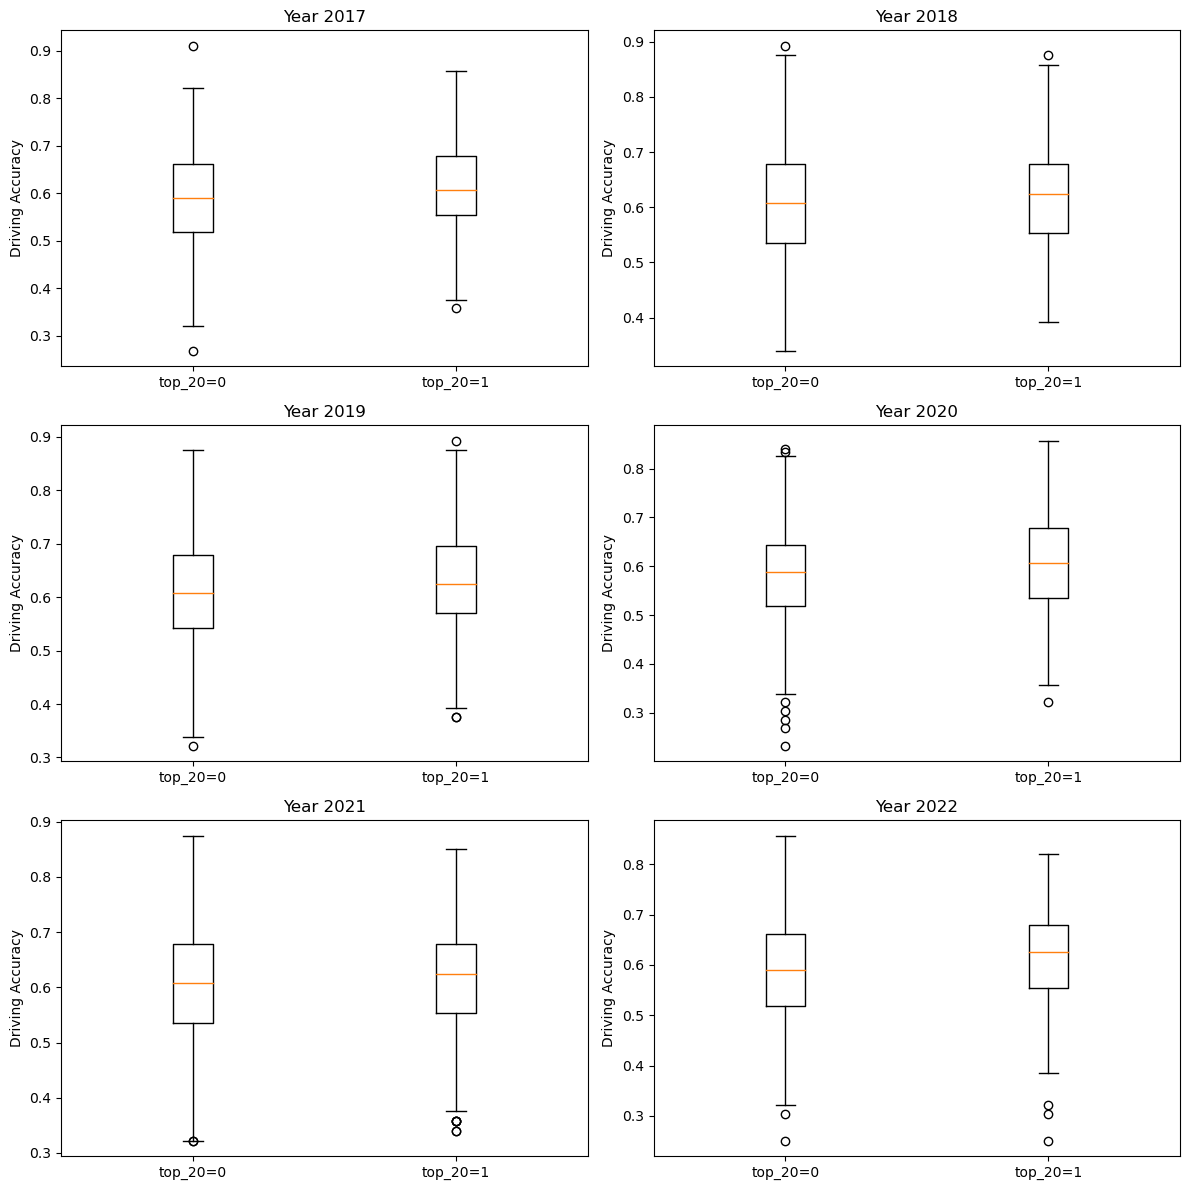

In [582]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

for year, axs in zip(np.unique(averaged_data['year'].values), axes.flatten()):
    # Get the driving distance data for top_20=0 and top_20=1 for the current year
    driving_acc_0 = averaged_data[(averaged_data['year'] == year) & (averaged_data['top_20'] == 0)]['driving_acc']
    driving_acc_1 = averaged_data[(averaged_data['year'] == year) & (averaged_data['top_20'] == 1)]['driving_acc']
    
    # Create boxplots for the current year
    axs.boxplot([driving_acc_0, driving_acc_1], labels=['top_20=0', 'top_20=1'])
    axs.set_title(f'Year {year}')
    axs.set_ylabel('Driving Accuracy')

# Adjust the layout of subplots
plt.tight_layout()

# Show the plot
plt.show()

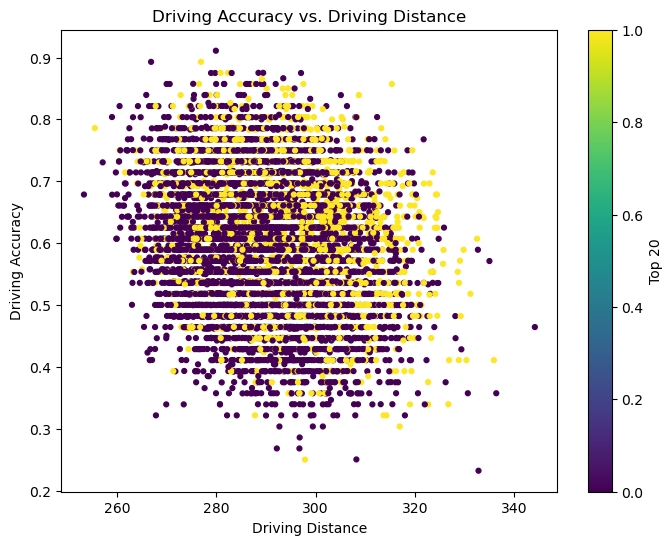

In [583]:
# Create a scatter plot of driving accuracy vs. driving distance
plt.figure(figsize=(8, 6))
plt.scatter(averaged_data['driving_dist'], averaged_data['driving_acc'],\
            c=averaged_data['top_20'], s=12)
plt.xlabel('Driving Distance')
plt.ylabel('Driving Accuracy')
plt.title('Driving Accuracy vs. Driving Distance')
plt.colorbar(label='Top 20')
plt.show()

We observe that players that place in the top 20 tend to drive the ball further and more accurately than those who do not.

# Classification Using More Lagged Features

We elect to create a predictive model using performance statistics averaged from the previous three events for each player in each year in order to predict whether they place in the top 20 in their next tournament. This again means we must drop some samples for players who do not have three events that year, or samples from early in the season, leaving us with 6981 samples to study.

## Preprocessing

In [584]:
lagged_features = l1_features

for var in features:
    averaged_data[f'{var}_l2'] = averaged_data.groupby(['year', 'dg_id'])[var].shift(2)
    lagged_features.append(f'{var}_l2')
    
    averaged_data[f'{var}_l3'] = averaged_data.groupby(['year', 'dg_id'])[var].shift(3)
    lagged_features.append(f'{var}_l3')

averaged_data.dropna(inplace=True)
averaged_data.reset_index(inplace=True)

three_round_avg_feat = []
for var in features:
    averaged_data[f'{var}_average'] = averaged_data[[f'{var}_l1',\
                    f'{var}_l2', f'{var}_l3']].mean(axis=1)
    three_round_avg_feat.append(f'{var}_average')

averaged_data.head()

index  year  event_id  dg_id  sg_putt   sg_arg   sg_app   sg_ott  \
0    333  2017        30  21554 -0.07225  0.29775 -0.51300  0.05850   
1    337  2017        30  18695 -0.19675 -0.18375  0.37700  0.52425   
2    347  2017        30  14926  1.39475  1.11900 -1.09125 -0.65200   
3    354  2017        30  13127  1.37800  0.61525 -1.08575  0.86250   
4    392  2017        33  11676  0.21675 -0.02500 -0.03475  0.93450   

   driving_dist     gir  ...  sg_putt_average  sg_arg_average  sg_app_average  \
0       292.750  0.6110  ...        -0.223250        0.097417        0.202250   
1       299.775  0.7085  ...         1.416667        0.904917       -0.602167   
2       276.375  0.6250  ...         0.547083        0.474083       -0.211583   
3       299.175  0.6945  ...         0.044417       -0.123000        0.601750   
4       304.100  0.5695  ...         0.431250        0.389750        0.742750   

   sg_ott_average  driving_dist_average  driving_acc_average  gir_average  \
0        0.523833            290.258333             0.571417     0.662250   
1        0.047083            298.891667             0.440500     0.583417   
2       -0.279750            281.333333             0.577333     0.634333   
3        0.813167            300.858333             0.535750     0.708250   
4        0.789417            297.975000             0.559500     0.676083   

   scrambling_average  prox_rgh_average  prox_fw_average  
0            0.606250         56.332417        27.864083  
1            0.739417         43.799500        36.648417  
2            0.692167         54.416750        30.028750  
3            0.583833         43.441750        30.869417  
4            0.724000         42.973583        29.865167  

[5 rows x 57 columns]

## Logistic Regression

In [585]:
X = averaged_data[three_round_avg_feat]
y = averaged_data['top_20']

# Normalize data
X_norm = StandardScaler().fit_transform(X)
X_norm = pd.DataFrame(X_norm, columns=three_round_avg_feat)

X_norm_train, X_norm_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=123)

# Define the range of C values to search
param_grid = {'C': np.logspace(-6, 2, 100)}

# Create a logistic regression model with L1 penalty
logreg = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000)

# Perform grid search with cross-validation
model = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
model.fit(X_norm_train, y_train)

print(f'Cross-validated training score: {model.best_score_.mean():.5f}')

# Get the best hyperparameters and the best model
best_alpha = model.best_params_
best = model.best_estimator_

# Compute the predicted probabilities for the test data
y_pred_proba = best.predict_proba(X_norm_test)[:, 1]

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the ROC AUC score
print(f"Test ROC AUC score: {roc_auc:.5f}")

# Print the best hyperparameters and the test score
print("Best alpha:", best_alpha)

# Get the coefficients of the best model
coefficients = best.coef_[0]

# Create a DataFrame to summarize the coefficients
coefficients_df = pd.DataFrame({'Feature': three_round_avg_feat, 'Coefficient': coefficients})

# Print the coefficients DataFrame sorted by coefficients in descending order
coefficients_df_sorted = coefficients_df.sort_values(by='Coefficient',
                                                     key=lambda x: abs(x),
                                                     ascending=False)
print(coefficients_df_sorted)

Cross-validated training score: 0.61120
Test ROC AUC score: 0.61823
Best alpha: {'C': 100.0}
                Feature  Coefficient
4  driving_dist_average     0.344774
6           gir_average    -0.256507
2        sg_app_average     0.214846
1        sg_arg_average     0.209420
5   driving_acc_average     0.174863
3        sg_ott_average     0.116036
0       sg_putt_average     0.104872
9       prox_fw_average    -0.098635
7    scrambling_average    -0.080566
8      prox_rgh_average     0.007102


We start with a logistic regression on the normalized features, which again tells the same story: that driving distance is the most important feature in predicting player performance relative to the other features. Although the regularization parameter is large, we observe better performance with a cross validated training ROC AUC of 0.6112, which puts us in the fair performance range for our model.

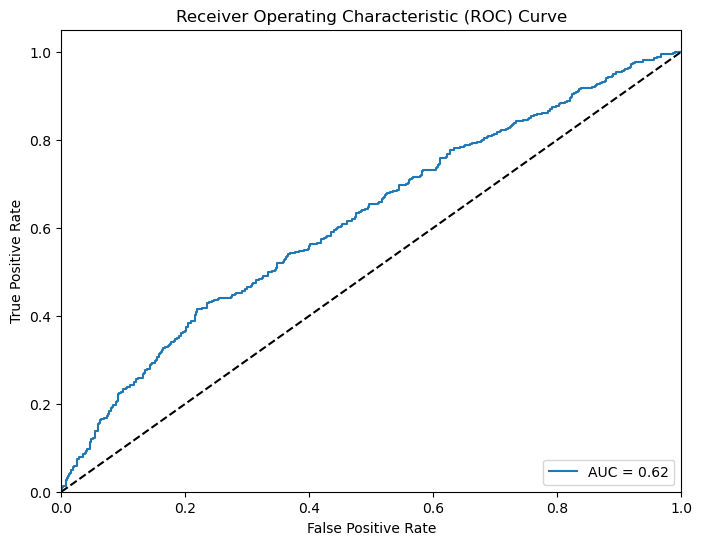

In [586]:
# Compute the false positive rate, true positive rate, and thresholds
logit_fpr, logit_tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the area under the ROC curve
logit_roc_auc = auc(logit_fpr, logit_tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(logit_fpr, logit_tpr, label=f'AUC = {logit_roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [587]:
# Compute optimal decision threshold
# from sklearn documentation:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
boundaries = []
scores = []

for train, test in cv.split(X_norm_train, y_train):
    best.fit(X_norm_train.iloc[train], y_train.iloc[train])
    # Compute the predicted labels for the test data
    y_prob = best.predict_proba(X_norm_train.iloc[test])[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train.iloc[test], y_prob)
    dist = np.sqrt((1-tpr)**2+(fpr)**2)
    optimal_index = np.argmin(dist)
    boundaries.append(thresholds[optimal_index])

# Get the cross-validated optimal threshold and corresponding F1 score
optimal_threshold = np.mean(boundaries)

print(f"Cross validated optimal threshold (from training): {optimal_threshold:.5f}")

Cross validated optimal threshold (from training): 0.33081


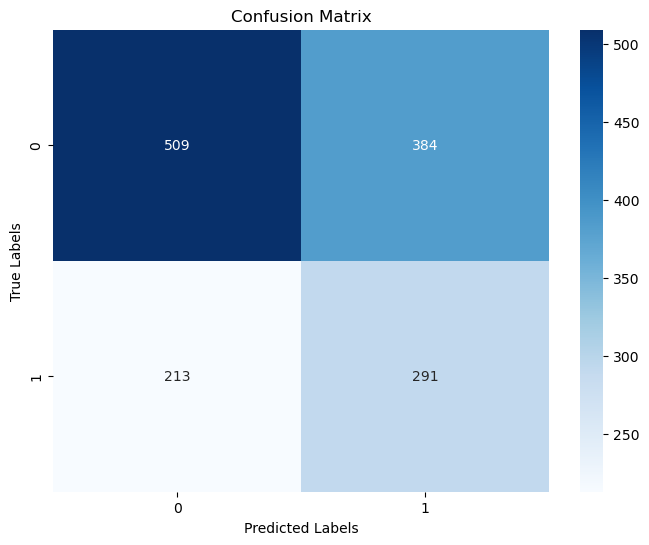

Accuracy: 0.572655690765927
Precision: 0.4311111111111111
Recall: 0.5773809523809523
F1 Score: 0.49363867684478363


In [588]:
# Compute the predicted labels for the test data
y_prob = best.predict_proba(X_norm_test)[:, 1]
y_pred = (y_prob >= optimal_threshold).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

## Decision Tree

Best ccp_alpha: 0.0029414586083829075
Cross validated training score: 0.56276
Test ROC AUC score: 0.58066


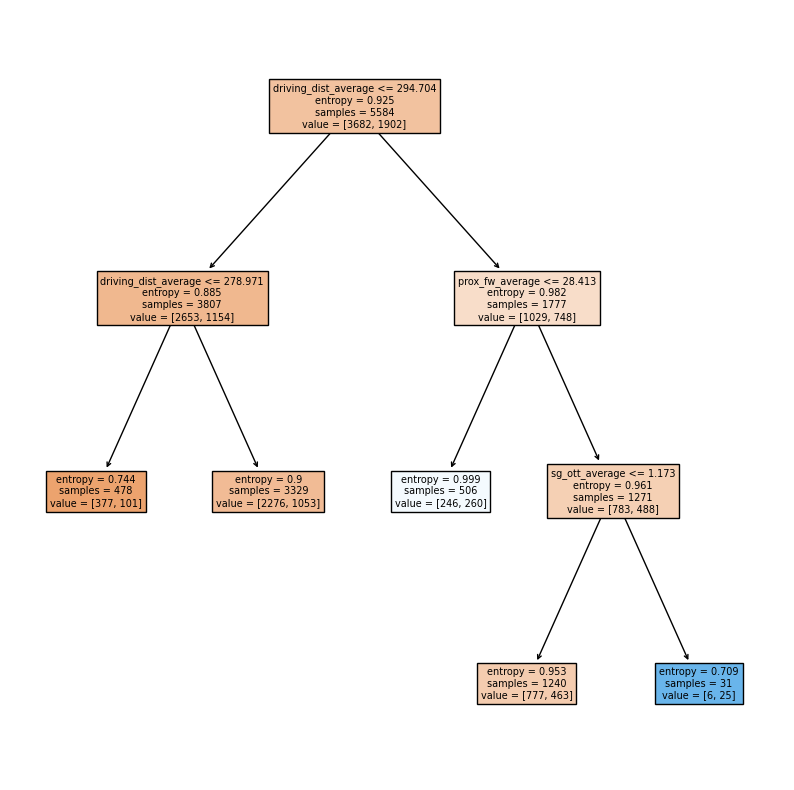

In [589]:
three_round_avg_feat.append('event_id')
X = averaged_data[three_round_avg_feat]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Create an instance of the DecisionTreeClassifier
tree = DTC(criterion='entropy')

# Fit the decision tree regressor to the data
tree.fit(X_train, y_train)

# Perform cost complexity pruning
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]

# Perform grid search to find the best hyperparameters
pruned = GridSearchCV(tree, {'ccp_alpha': ccp_alphas}, cv=5, n_jobs=-1, scoring='roc_auc')
pruned.fit(X_train, y_train)

# Get the best hyperparameters and the best model
best_ccp_alpha = pruned.best_params_['ccp_alpha']
best = pruned.best_estimator_

print("Best ccp_alpha:", best_ccp_alpha)
print(f"Cross validated training score: {pruned.best_score_.mean():.5f}")

# Compute the predicted probabilities for the test data
y_pred_proba = best.predict_proba(X_test)[:, 1]

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the ROC AUC score
print(f"Test ROC AUC score: {roc_auc:.5f}")

# Plot the decision tree
plt.figure(figsize=(10, 10))
plot_tree(best, feature_names=three_round_avg_feat, filled=True)
plt.show()

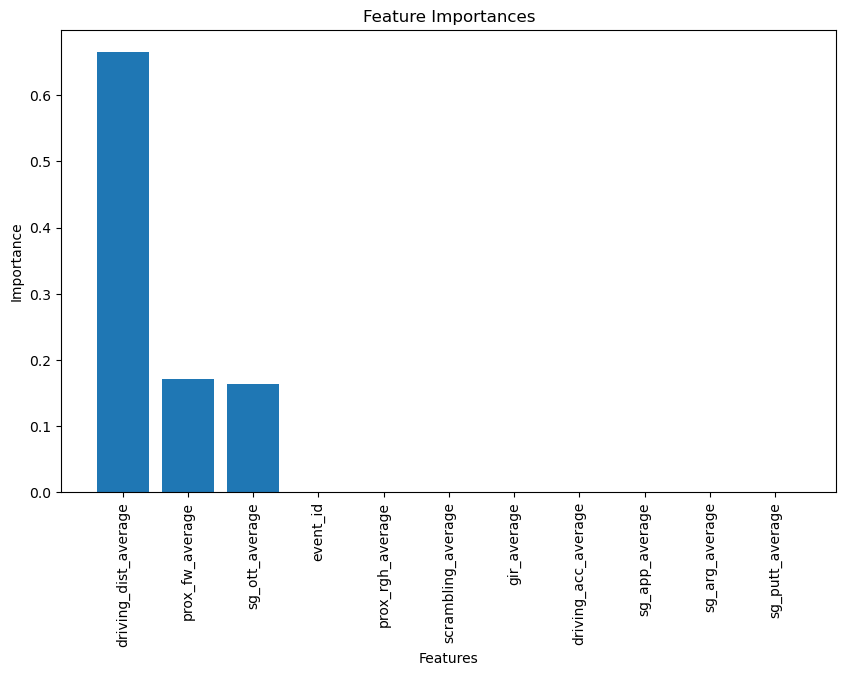

In [590]:
# Get the feature importances from the trained decision tree model
importances = best.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), np.array(three_round_avg_feat)[indices.astype(int)], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

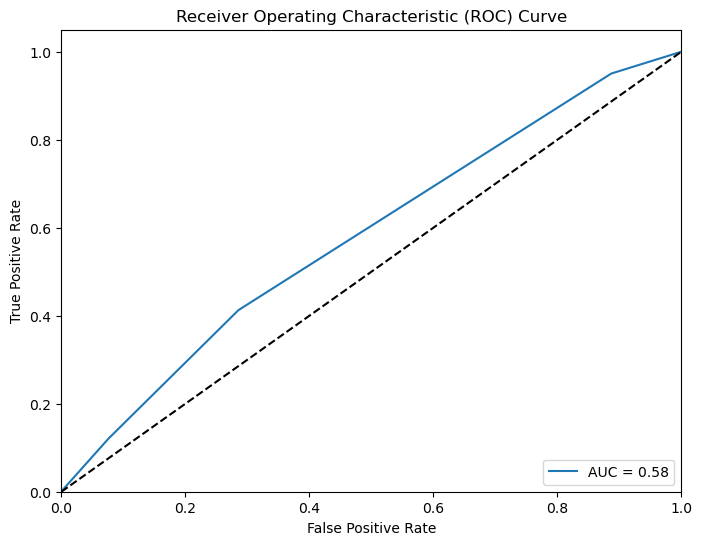

In [591]:
# Compute the false positive rate, true positive rate, and thresholds
dtc_fpr, dtc_tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the area under the ROC curve
dtc_roc_auc = auc(dtc_fpr, dtc_tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(dtc_fpr, dtc_tpr, label=f'AUC = {dtc_roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [592]:
# Compute optimal decision threshold
# from sklearn documentation:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
boundaries = []
scores = []

for train, test in cv.split(X_train, y_train):
    best.fit(X_train.iloc[train], y_train.iloc[train])
    # Compute the predicted labels for the test data
    y_prob = best.predict_proba(X_train.iloc[test])[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train.iloc[test], y_prob)
    dist = np.sqrt((1-tpr)**2+(fpr)**2)
    optimal_index = np.argmin(dist)
    boundaries.append(thresholds[optimal_index])

# Get the cross-validated optimal threshold and corresponding F1 score
optimal_threshold = np.mean(boundaries)

print(f"Cross validated optimal threshold (from training): {optimal_threshold:.5f}")

Cross validated optimal threshold (from training): 0.35784


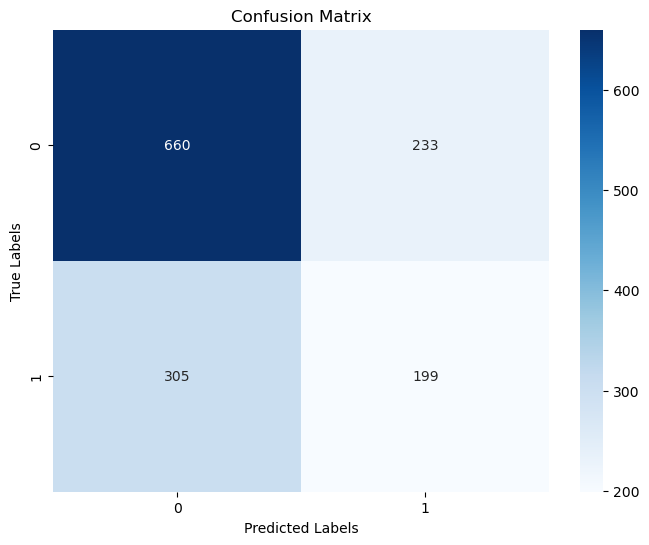

Accuracy: 0.6148890479599141
Precision: 0.46064814814814814
Recall: 0.3948412698412698
F1 Score: 0.42521367521367526


In [593]:
# Compute the predicted labels for the test data
y_prob = best.predict_proba(X_test)[:,1]
y_pred = (y_prob >= optimal_threshold).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

## Gradient Boosting Classifier

In [594]:
# Create an instance of the GradientBoostingClassifier
boosting_tree = GBC(n_estimators=1000,
                    learning_rate=0.001,
                    max_depth=None,
                    random_state=123)

param_grid = {'max_leaf_nodes': range(8,12,2)}

# Hyperparameter tuning
model = GridSearchCV(boosting_tree, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
model.fit(X_train, y_train)

# Get the best hyperparameters and the best model
best_nodes = model.best_params_['max_leaf_nodes']
best = model.best_estimator_

print("Best number of terminal nodes:", best_nodes)
print(f"Cross validated training score: {model.best_score_.mean():.5f}")

# Compute the predicted probabilities for the test data
y_pred_proba = best.predict_proba(X_test)[:, 1]

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the ROC AUC score
print(f"Test ROC AUC: {roc_auc:.5f}")

Best number of terminal nodes: 8
Cross validated training score: 0.58400
Test ROC AUC: 0.59662


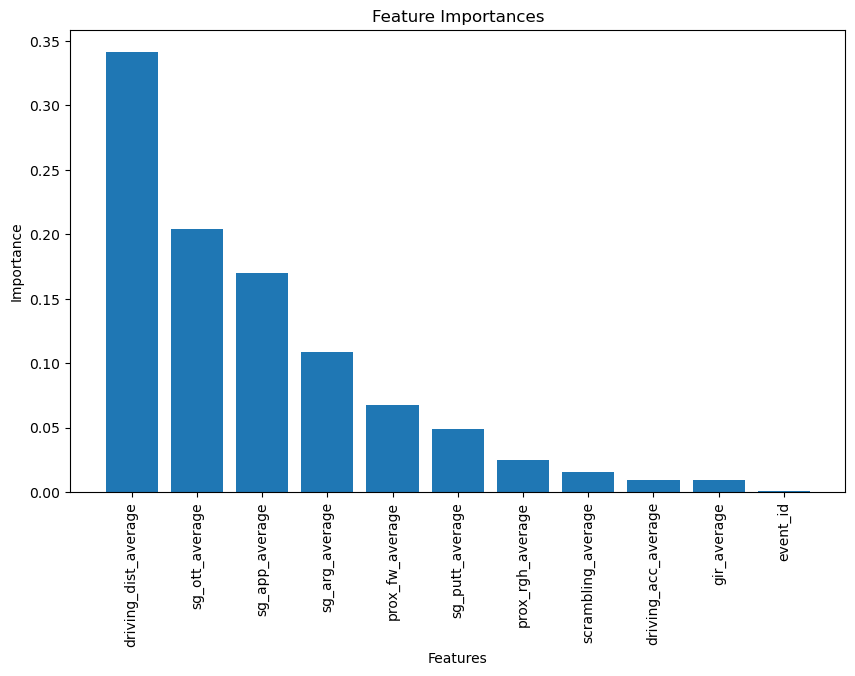

In [595]:
# Get the feature importances from the trained decision tree model
importances = best.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), np.array(three_round_avg_feat)[indices.astype(int)], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

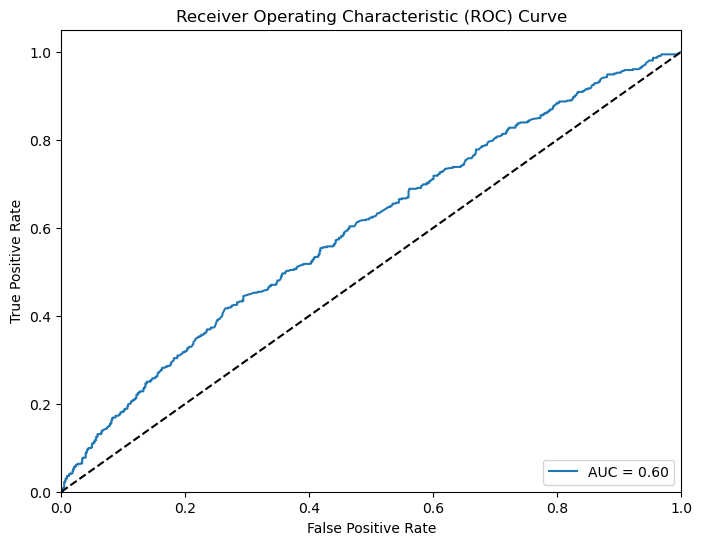

In [596]:
# Compute the false positive rate, true positive rate, and thresholds
gbc_fpr, gbc_tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the area under the ROC curve
gbc_roc_auc = auc(gbc_fpr, gbc_tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(gbc_fpr, gbc_tpr, label=f'AUC = {gbc_roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [597]:
# Compute optimal decision threshold
# from sklearn documentation:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
boundaries = []
scores = []

for train, test in cv.split(X_train, y_train):
    best.fit(X_train.iloc[train], y_train.iloc[train])
    # Compute the predicted labels for the test data
    y_prob = best.predict_proba(X_train.iloc[test])[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train.iloc[test], y_prob)
    dist = np.sqrt((1-tpr)**2+(fpr)**2)
    optimal_index = np.argmin(dist)
    boundaries.append(thresholds[optimal_index])

# Get the cross-validated optimal threshold and corresponding F1 score
optimal_threshold = np.mean(boundaries)

print(f"Cross validated optimal threshold (from training): {optimal_threshold:.5f}")

Cross validated optimal threshold (from training): 0.33147


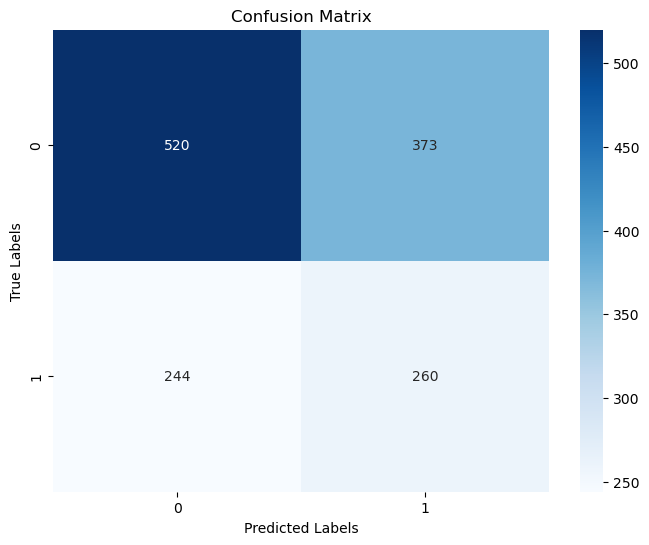

Accuracy: 0.5583392984967788
Precision: 0.4107424960505529
Recall: 0.5158730158730159
F1 Score: 0.4573438874230431


In [598]:
# Compute the predicted labels for the test data
y_prob = best.predict_proba(X_test)[:,1]
y_pred = (y_prob >= optimal_threshold).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

## Random Forest Classifier

In [599]:
# Create an instance of the RandomForestClassifier
random_forest = RFC(n_estimators=1000, criterion='entropy', 
                    n_jobs=-1, random_state=123)

param_grid = {'max_leaf_nodes': range(8,33,2)}

# Regularize by number of terminal nodes
model = GridSearchCV(random_forest, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
model.fit(X_train, y_train)

# Get the best hyperparameters and the best model
best_nodes = model.best_params_['max_leaf_nodes']
best = model.best_estimator_

print("Best number of terminal nodes:", best_nodes)
print(f"Cross validated training score: {model.best_score_.mean():.5f}")

# Compute the predicted probabilities for the test data
y_pred_proba = best.predict_proba(X_test)[:, 1]

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the ROC AUC score
print(f"Test ROC AUC score: {roc_auc:.5f}")

Best number of terminal nodes: 22
Cross validated training score: 0.59008
Test ROC AUC score: 0.60949


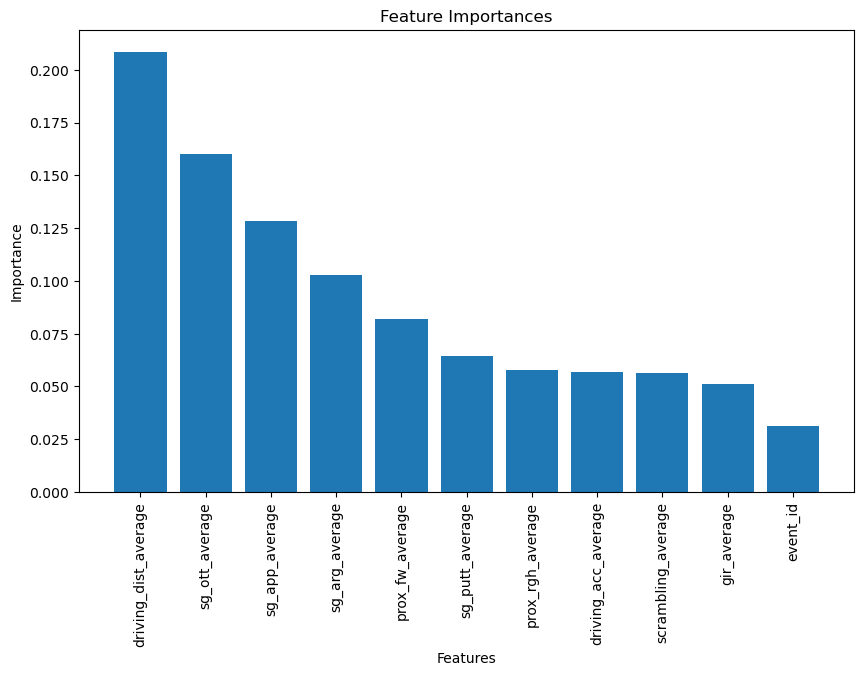

In [600]:
# Get the feature importances from the trained decision tree model
importances = best.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), np.array(three_round_avg_feat)[indices.astype(int)], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

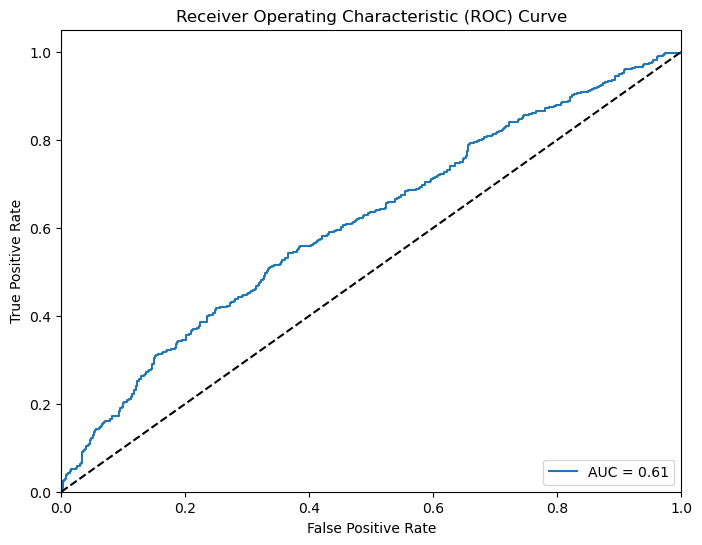

In [601]:
# Compute the false positive rate, true positive rate, and thresholds
rfc_fpr, rfc_tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the area under the ROC curve
rfc_roc_auc = auc(rfc_fpr, rfc_tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(rfc_fpr, rfc_tpr, label=f'AUC = {rfc_roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [602]:
# Compute optimal decision threshold
# from sklearn documentation:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
boundaries = []
scores = []

for train, test in cv.split(X_train, y_train):
    best.fit(X_train.iloc[train], y_train.iloc[train])
    # Compute the predicted labels for the test data
    y_prob = best.predict_proba(X_train.iloc[test])[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train.iloc[test], y_prob)
    dist = np.sqrt((1-tpr)**2+(fpr)**2)
    optimal_index = np.argmin(dist)
    boundaries.append(thresholds[optimal_index])

# Get the cross-validated optimal threshold and corresponding F1 score
optimal_threshold = np.mean(boundaries)

print(f"Cross validated optimal threshold (from training): {optimal_threshold:.5f}")

Cross validated optimal threshold (from training): 0.33151


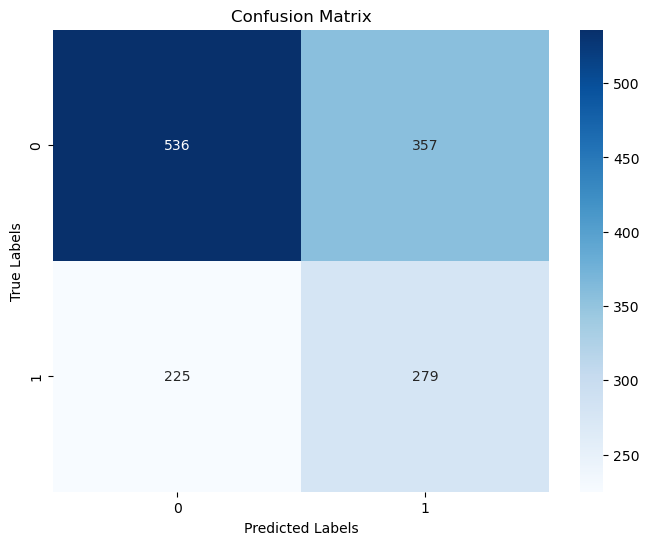

Accuracy: 0.5833929849677881
Precision: 0.4386792452830189
Recall: 0.5535714285714286
F1 Score: 0.4894736842105264


In [603]:
# Compute the predicted labels for the test data
y_prob = best.predict_proba(X_test)[:,1]
y_pred = (y_prob >= optimal_threshold).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

## Naive Bayes Classifier

In [604]:
# Create an instance of the GaussianNB classifier
param_grid = {'var_smoothing': np.logspace(-6, 2, 100)}
# Fit the classifier to the training data
model = GridSearchCV(GaussianNB(), param_grid, cv=5, n_jobs=-1,\
                    scoring='roc_auc')

# Fit the model to the training data
model.fit(X_norm_train, y_train)

# Get the best hyperparameters and the best model
best = model.best_estimator_

print("Best parameters:", model.best_params_)
print(f"Cross validated training ROC AUC: {model.best_score_.mean():.5f}")

# Compute the predicted probabilities for the test data
y_pred_prob = best.predict_proba(X_norm_test)[:, 1]

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Print the ROC AUC score
print(f"Test ROC AUC score: {roc_auc:.5f}")

Best parameters: {'var_smoothing': 22.570197196339215}
Cross validated training ROC AUC: 0.58744
Test ROC AUC score: 0.60257


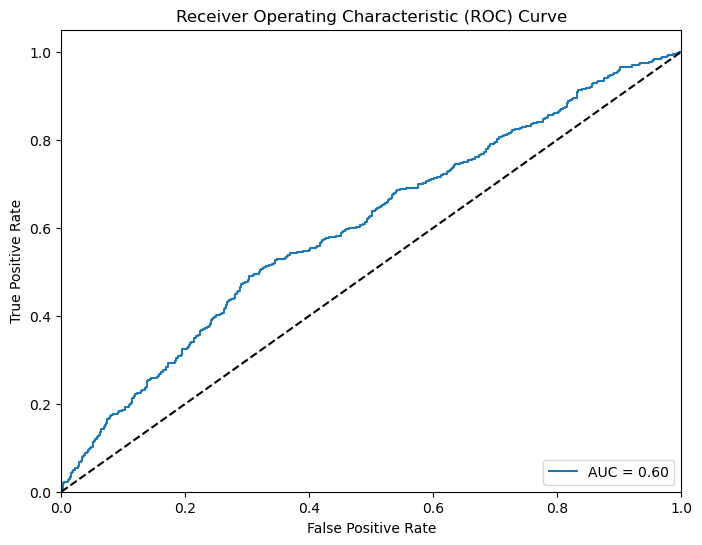

In [605]:
# Compute the false positive rate, true positive rate, and thresholds
nb_fpr, nb_tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the area under the ROC curve
nb_roc_auc = auc(nb_fpr, nb_tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(nb_fpr, nb_tpr, label=f'AUC = {nb_roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [606]:
# Compute optimal decision threshold
# from sklearn documentation:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
boundaries = []
scores = []

for train, test in cv.split(X_norm_train, y_train):
    best.fit(X_norm_train.iloc[train], y_train.iloc[train])
    # Compute the predicted labels for the test data
    y_prob = best.predict_proba(X_norm_train.iloc[test])[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train.iloc[test], y_prob)
    dist = np.sqrt((1-tpr)**2+(fpr)**2)
    optimal_index = np.argmin(dist)
    boundaries.append(thresholds[optimal_index])

# Get the cross-validated optimal threshold and corresponding F1 score
optimal_threshold = np.mean(boundaries)

print(f"Cross validated optimal threshold (from training): {optimal_threshold:.5f}")

Cross validated optimal threshold (from training): 0.33911


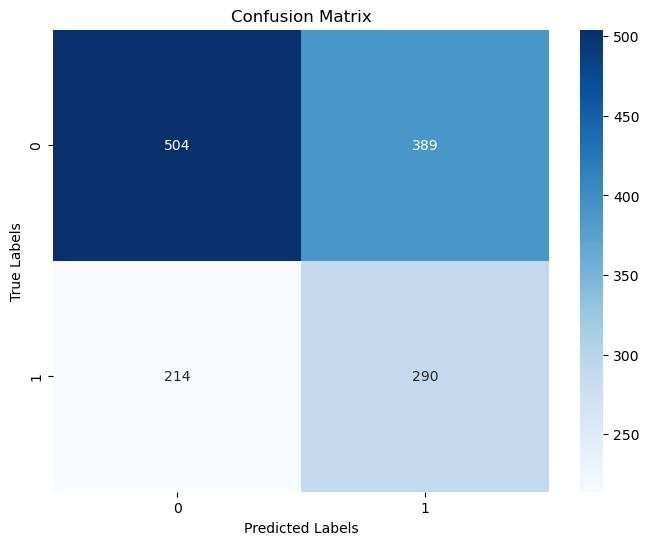

Accuracy: 0.5683607730851825
Precision: 0.4270986745213549
Recall: 0.5753968253968254
F1 Score: 0.4902789518174133


In [607]:
# Compute the predicted labels for the test data
y_prob = best.predict_proba(X_norm_test)[:,1]
y_pred = (y_prob >= optimal_threshold).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

## Aside: Comparison of ROC Curves

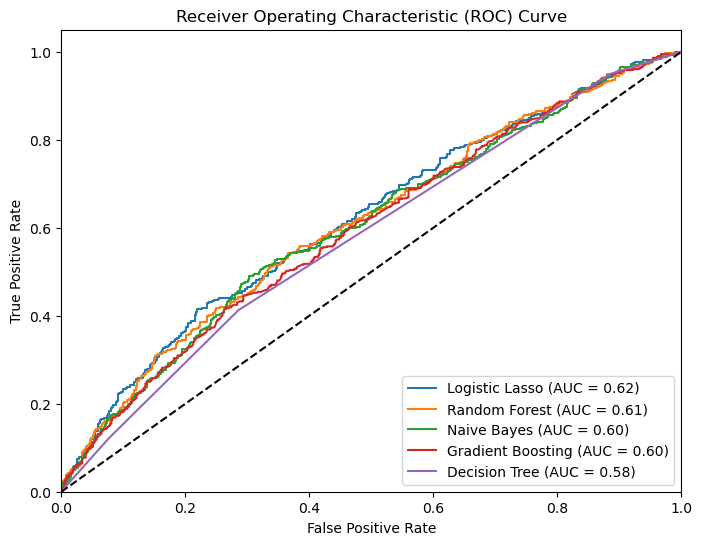

In [608]:
plt.figure(figsize=(8, 6))
plt.plot(logit_fpr, logit_tpr, label=f'Logistic Lasso (AUC = {logit_roc_auc:.2f})')
plt.plot(rfc_fpr, rfc_tpr, label=f'Random Forest (AUC = {rfc_roc_auc:.2f})')
plt.plot(nb_fpr, nb_tpr, label=f'Naive Bayes (AUC = {nb_roc_auc:.2f})')
plt.plot(gbc_fpr, gbc_tpr, label=f'Gradient Boosting (AUC = {gbc_roc_auc:.2f})')
plt.plot(dtc_fpr, dtc_tpr, label=f'Decision Tree (AUC = {dtc_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

We observe again, across the board, driving distance is the most important feature in predicting player performance relative to all other statistics available on the PGA Tour site. We note that averaging statistics over the previous three events improved performance across the board and we were able to fit more accurate models because of it. Most of the models were able to obtain a test ROC AUC of 0.6 or higher which is fair performance for a classification models, and suggests that the models are learning some predictive relationships in the data.

We elected to choose the optimal decision boundary in each model by the distance to the point (0,1) on the ROC Curve graph because it gave us more sensible results. Not included in this notebook, but when we attempted a similar approach fitting by 'average_precision' and selecting an optimal boundary from the point (1,1) on the precision-recall graph we obtained a higher test f1-score which was dominated by an inflated recall because the model was assigning a significant majority of positive predictions to the observations. When using the optimal decision boundary as we did above, we model assigned close to 40% of the observations a positive label. While this could be purely a factor of the distribution of the train-test split, it seemed much more reasonable to suspect as that would assign a smaller cohort of players in each event a positive prediction.

# Results

We observe a consistent story among the features available to us in the dataset: driving distance is the most important predictor of player performance on the PGA Tour relative to all the other performance statistics available. In addition, we observed the trend referred to by the USGA in their argument for golf ball rollback: that driving distance on tour has been increasing year after year, and skills are not improving at the same time. In other words, the improvements in technology are allowing players to play courses differently than their design intended. Distance allows certain player to avoid certain challenges posed by the courses design, and therefore eliminates some of the skill and course management aspects of tournament play. We observe this from driving distance being the most important feature in predicting player performance, above the skills represented by the different strokes gained categories and other statistics. Overall, driving distance does appear to give players a certain advantage in elite play and is a viable measure of player performance across the board.

One possible extension of this project could be to incorporate weather data into the predictive models. We observed sub-par performance even in our ultimate model, which suggests the variation in performance is not entirely captured by performance statistics. This is a very reasonable hypothesis, as a player who performs very well in good weather conditions may struggle in bad weather, whereas other players may perform consistently across the board. If we could include a feature that measures the weather in that round, or the average weather conditions across the event, we may be able to improve the performance of the model and reevaluate the importance of driving distance in terms of performance predictive power.